In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [3]:
def myCurve(x, a, b, c):
    
    x0 = -b/2./a
    y = a*x**2+b*x+c
    
    indx, = np.where(x>=x0)
    y[indx] = a*x0**2+b*x0+c
    
    indx, = np.where(x<-21)
    x0 = -21.
    y[indx] = a*x0**2+b*x0+c
    
    return y

########################################################

In [4]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [5]:
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod

In [6]:
inFile  = '../EDD_distance_cf4_v27.csv'
grand_tbl   = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None)
grand_pgc = grand_tbl['pgc']
ggl = grand_tbl['gl']
ggb = grand_tbl['gb']


inFile  = 'allTF4_pgc1_nest.csv'
allPGC1   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)
PGC_all1 = allPGC1['PGC']
RA_all1 = allPGC1['RA']
DEC_all1 = allPGC1['DEC']

indx, = np.where(PGC_all1==5066224)
PGC_all1[indx]=45311

indx, = np.where(PGC_all1==5077211)
PGC_all1[indx]=47027


inFile  = 'Vgp_adds.spgc.csv'
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)
PGC_Vgp = table['PGC']
Vmod_Vgp = table['Vmod']
PGC1_Vgp = table['PGC1']
Nest_Vgp = table['Nest']
Vmodg_Vgp = table['Vmodg']
Nkt_Vgp = table['Nkt']
N15_Vgp = table['N15']
sglg_Vgp = table['sglg']
sgbg_Vgp = table['sgbg']


inFile  = 'CF4_TFdist_extras.csv'
table   = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None)
PGC_allCF4 = table['PGC']
Vmod_allCF4 = table['Vmod']
PGC1_allCF4 = table['PGC1']
Nest_allCF4 = table['Nest']
Vmodg_allCF4 = table['Vmodg']
Nkt_allCF4 = table['Nkt']
N15_allCF4 = table['N15']
sglg_allCF4 = table['SGLg']
sgbg_allCF4 = table['SGBg']

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [7]:
table = np.genfromtxt('DMall10736_V.spgc.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

PGC_vh = table['PGC']
Vh_vh  = table['Vh']
Vls_vh = table['Vls']
V3k_vh = table['V3k']

indx, = np.where(PGC_vh==5066224)
PGC_vh[indx]=45311

indx, = np.where(PGC_vh==5077211)
PGC_vh[indx]=47027

table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

indx, = np.where(pgc_catal==5066224)
pgc_catal[indx]=45311

indx, = np.where(pgc_catal==5077211)
pgc_catal[indx]=47027

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
ince_tab = table['inc_e']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
Wmx_tab = table['Wmx']
eWmx_tab = table['eWmx']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']

A_p_i = table['A_p_i']
Ai    = table['Ai']


eWmx_tab[eWmx_tab<5] = 5
deg2rad = 3.1415/180.
alfa = inc_tab*deg2rad
d_alfa = ince_tab*deg2rad
logWimx_e = np.sqrt((eWmx_tab/Wmx_tab)**2+(d_alfa/np.tan(alfa))**2)/np.log(10)


Vhel = table['Vhel']
Vls = table['Vls']

Vmod = Vhel*0.
V3k = Vhel*0.


indx, = np.where(pgc_tab==5066224)
pgc_tab[indx]=45311

indx, = np.where(pgc_tab==5077211)
pgc_tab[indx]=47027



inFile  = '../EDD_distance_cf4_v27.csv'
grand_tbl   = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None)
grand_pgc = grand_tbl['pgc']


indx, = np.where(grand_pgc==5066224)
grand_pgc[indx]=45311

indx, = np.where(grand_pgc==5077211)
grand_pgc[indx]=47027

ggl  = grand_tbl['gl']
ggb  = grand_tbl['gb']
ssgl = grand_tbl['sgl']
ssgb = grand_tbl['sgb']

N = len(pgc_tab)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)


ra = np.zeros(N)
dec = np.zeros(N)
pgc1 = np.zeros(N)
nest = np.zeros(N)
sglg = np.zeros(N)
sgbg = np.zeros(N)
Vmodg = np.zeros(N)
Nkt = np.zeros(N)
N15 = np.zeros(N)

gl  = np.zeros(N)
gb  = np.zeros(N)
sgl = np.zeros(N)
sgb = np.zeros(N)
PP= 0 
for i, idd in enumerate(pgc_tab):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
        
    if idd in grand_pgc:
        indx,  = np.where(grand_pgc==idd)    
        gl[i]  = ggl[indx][0]
        gb[i]  = ggb[indx][0]  
        sgl[i] = ssgl[indx][0]
        sgb[i] = ssgb[indx][0] 
    if idd in PGC_vh:
        PP+=1
        try:
            indx,  = np.where(PGC_vh==idd) 
            Vhel[i] = Vh_vh[indx][0]
            Vls[i]  = Vls_vh[indx][0]
            V3k[i]  = V3k_vh[indx][0]
        except:
            print idd
    if idd in PGC_all1:
        try:
            indx,   = np.where(PGC_all1==idd) 
            ra[i]   = RA_all1[indx][0]
            dec[i]  = DEC_all1[indx][0]
        except:
            print idd
    if idd in PGC_Vgp:
        try:
            indx,   = np.where(PGC_Vgp==idd) 
            pgc1[i] = PGC1_Vgp[indx][0]
            nest[i] = Nest_Vgp[indx][0]
            Vmod[i] = Vmod_Vgp[indx][0]
            Vmodg[i] = Vmodg_Vgp[indx][0]
            Nkt[i]  = Nkt_Vgp[indx][0]
            N15[i]  = N15_Vgp[indx][0]
            sglg[i] = sglg_Vgp[indx][0]
            sgbg[i] = sgbg_Vgp[indx][0]
        except:
            print idd            
    if idd in PGC_allCF4:
        try:
            indx,   = np.where(PGC_allCF4==idd) 
            pgc1[i] = PGC1_allCF4[indx][0]
            nest[i] = Nest_allCF4[indx][0]
            Vmod[i] = Vmod_allCF4[indx][0]
            Vmodg[i] = Vmodg_allCF4[indx][0]
            Nkt[i]  = Nkt_allCF4[indx][0]
            N15[i]  = N15_allCF4[indx][0]
            sglg[i] = sglg_allCF4[indx][0]
            sgbg[i] = sgbg_allCF4[indx][0]
        except:
            pass      
            
            
            
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


for i, id in enumerate(pgc_tab):
    
    if R50w1[i]<=0 and R50w2[i]>0:
        R50w1[i] = R50w2[i]
    elif R50w2[i]<=0 and R50w1[i]>0:
        R50w2[i] = R50w1[i]
    elif R50w2[i]<=0 and R50w1[i]<=0:
        WWqlt[i] = 0
        
mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22
r_z   = rrr-zzz
g_r   = ggg-rrr
r_z   = rrr-zzz

print PP

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


10736


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:216: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:216: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:217: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:219: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:219: RuntimeWarning

In [8]:
####################################
def TFRcurve(logW, slope, zp, A, band):


    if band in ['w1', 'w2']:
        logW0=2.4 
    else:
        logW0=2.5

    X0 = logW0 - 2.5
    X = logW-2.5
    B = -2.*A*X0
    M = slope*X+(zp)
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

def DMcalc(logW, mag, band='i', deltaDM=0, dlogW=None):
    
    dmag = 0.05
    ds=0; dzp=0
    if band=='u':
        dmag = 0.1
        slope=-7.03 ; zp=-19.27; Czp=-0.08; A2=6.59
        ds = 0.17 ; dzp = 0.13
    elif band=='g':
        slope=-7.37 ; zp=-20.15; Czp=-0.11; A2=4.18
        ds = 0.13 ; dzp = 0.11
    elif band=='r':
        slope=-7.96 ; zp=-20.57; Czp=-0.08; A2=4.56   
        ds = 0.13 ; dzp = 0.10
    elif band=='i':
        slope=-8.32 ; zp=-20.80; Czp=-0.04; A2=5.34
        ds = 0.13 ; dzp = 0.10
    elif band=='z':
        slope=-8.46 ; zp=-20.89; Czp=-0.08; A2=5.81 
        ds = 0.13 ; dzp = 0.10
    elif band=='w1':
        slope=-9.47 ; zp=-20.36; Czp=0.0; A2=3.81
        ds = 0.14 ; dzp = 0.07
    elif band=='w2':
        slope=-9.66 ; zp=-19.76; Czp=0.0; A2=4.42
        ds = 0.14 ; dzp = 0.07
    
#     A2 = 0
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    DM = (mag-MAG) + deltaDM
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
        return DM, dDM
    else:
        return DM
    
###################################  
def DMcalcWc(logW, mag, i_w, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_i_w1 = i_w - (1.18*(logW-2.5)-0.47)
        magCorrection = -1*(-1.08*(D_i_w1)-0.04)
        mag_c = mag + magCorrection
        slope=-9.27 ; zp=-20.29; Czp=0.0; A2=0
        ds = 0.13 ; dzp = 0.10
    elif band=='w2':
        D_i_w2 = i_w - (1.32*(logW-2.5)-1.04)
        magCorrection = -1*(-1.09*(D_i_w2)-0.07)
        mag_c = mag + magCorrection
        slope=-9.40 ; zp=-19.70; Czp=0.0; A2=0         
        ds = 0.14 ; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  
def DMcalcWmu(logW, mag, mu50, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_mu50_w1 = mu50 - (-4.05*(logW-2.5)+22.63)
        magCorrection = -1*(0.16*(D_mu50_w1)-0.05)
        mag_c = mag + magCorrection
        slope=-9.15 ; zp=-20.26; Czp=0.0; A2=2.55
        ds = 0.13 ; dzp = 0.07
    elif band=='w2':
        D_mu50_w2 = mu50 - (-4.06*(logW-2.5)+23.21)
        magCorrection = -1*(0.19*(D_mu50_w2)-0.07)
        mag_c = mag + magCorrection
        slope=-9.18 ; zp=-19.62; Czp=0.0; A2=2.67 
        ds = 0.13 ; dzp = 0.07
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  

def DMcalcWm21(logW, mag, m21_w, band='w1', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='w1':
        D_m21_w1 = m21_w - (3.27*(logW-2.5)+2.22)
        magCorrection = -1*(-0.10*(D_m21_w1))
        mag_c = mag + magCorrection
        slope=-9.12 ; zp=-20.29; Czp=0.0; A2=3.35
        ds = 0.13 ; dzp = 0.08
    elif band=='w2':
        D_m21_w2 = m21_w - (3.32*(logW-2.5)+1.65)
        magCorrection = -1*(-0.12*(D_m21_w2)-0.01)
        mag_c = mag + magCorrection
        slope=-9.22 ; zp=-19.67; Czp=0.0; A2=3.79  
        ds = 0.14; dzp = 0.08
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################  

def DMcalcOPc(logW, mag, g_i, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='u':
        u_i = g_i
        magCorrection = -1*(0.76*(u_i)-1.13)
        mag_c = mag + magCorrection
        slope=-7.88 ; zp=-19.31; Czp=-0.08; A2=5.03
        ds = 0.17; dzp = 0.13
    elif band=='g':
        magCorrection = -1*(0.73*(g_i)-0.45)
        mag_c = mag + magCorrection
        slope=-8.04 ; zp=-20.18; Czp=-0.11; A2=4.91
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_i)-0.27)
        mag_c = mag + magCorrection
        slope=-8.41 ; zp=-20.59; Czp=-0.08; A2=3.59
        ds = 0.13; dzp = 0.10
    elif band=='i':
        D_g_i = g_i - (0.84*(logW-2.5)+0.64)
        magCorrection = -1*(-0.31*(D_g_i))
        mag_c = mag + magCorrection
        slope=-8.22 ; zp=-20.80; Czp=-0.04; A2=3.91
        ds = 0.13; dzp = 0.10
    elif band=='z':
        D_g_i = g_i - (0.84*(logW-2.5)+0.64)
        magCorrection = -1*(-0.39*(D_g_i))
        mag_c = mag + magCorrection
        slope=-8.33 ; zp=-20.88; Czp=-0.08; A2=4.96
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
    
####################################
def DMcalcOPmu(logW, mag, mu50, band='i', deltaDM=0, dlogW=None):
    
    dmag = 0.05
    ds=0; dzp=0
    if band=='r':
        D_mu50_r = mu50 - (-2.70*(logW-2.5)+22.74)
        magCorrection = -1*(0.06*(D_mu50_r)-0.01)
        mag_c = mag + magCorrection
        slope=-7.89 ; zp=-20.55; Czp=-0.08; A2=4.34
        ds = 0.13; dzp = 0.1
    elif band=='i':
        D_mu50_i = mu50 - (-3.12*(logW-2.5)+22.48)
        magCorrection = -1*(0.06*(D_mu50_i)-0.02)
        mag_c = mag + magCorrection
        slope=-8.23 ; zp=-20.77; Czp=-0.04; A2=5.03
        ds = 0.13; dzp = 0.1
    elif band=='z':
        D_mu50_z = mu50 - (-3.45*(logW-2.5)+22.26)
        magCorrection = -1*(0.07*(D_mu50_z)-0.02)
        mag_c = mag + magCorrection
        slope=-8.35 ; zp=-20.86; Czp=-0.08; A2=3.88
        ds = 0.13; dzp = 0.07
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    DM = (mag_c-MAG) + deltaDM
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
        return DM, dDM
    else:
        return DM
    
####################################

def DMcalcOPcz(logW, mag, g_z, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='g':
        magCorrection = -1*(0.73*(g_z)-0.45)
        mag_c = mag + magCorrection
        slope=-7.58 ; zp=-20.16; Czp=-0.11; A2=4.74
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_z)-0.27)
        mag_c = mag + magCorrection
        slope=-8.11 ; zp=-20.57; Czp=-0.08; A2=4.98
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM
 ####################################

def DMcalcOPcr(logW, mag, g_r, band='i', deltaDM=0, dlogW=None):
    dmag = 0.05
    ds=0; dzp=0
    if band=='g':
        magCorrection = -1*(0.73*(g_r)-0.45)
        mag_c = mag + magCorrection
        slope=-8.04 ; zp=-20.17; Czp=-0.11; A2=4.64
        ds = 0.13; dzp = 0.10
    elif band=='r':
        magCorrection = -1*(0.44*(g_r)-0.27)
        mag_c = mag + magCorrection
        slope=-8.40 ; zp=-20.58; Czp=-0.08; A2=5.06
        ds = 0.13; dzp = 0.10
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    
    if not dlogW is None:
        dMAG2 = (ds*(logW-2.5))**2+dzp**2+(slope*dlogW)**2
        dDM = np.sqrt(dmag**2+dMAG2)
    
    
    DM = (mag_c-MAG) + deltaDM
    
    if dlogW is None:
        return DM
    else: 
        return DM, dDM

In [9]:
def getWe_bound(err):
    
    E = [0, 0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.80]
    for i, e in enumerate(E[:-1]):
        
        if err==e:
            return np.asarray([e,e])
        
        if err>e and err<E[i+1]:
            return np.asarray([e, E[i+1]])
    
    if err==E[i+1]:
        return np.asarray([E[i+1], E[i+1]])
    else: return None     
  
###############################

def getW_bound(logWimx):
    
    W = np.arange(1,3.1,0.1)
    N = len(W)
    for i in range(N-1):
        
        if logWimx==W[i]:
            return np.asarray([logWimx, logWimx])
        
        if logWimx>W[i] and logWimx<W[i+1]:
            return np.asarray([W[i], W[i+1]])
    
    if logWimx==W[i+1]:
        return np.asarray([W[i+1], W[i+1]])
    else: return None   
    

def intepBias(df, logWimx, err):
    
    Ebound = getWe_bound(err)
    Wbound = getW_bound(logWimx)
    i_Wbound = (Wbound-1)/0.1
    
    
    if err>0.4:
        Ebound = np.asarray([0.2, 0.4])
        
        e00 = df['%.2F'%Ebound[0]][int(i_Wbound[0])]
        if e00<0: e00=0
        e01 = df['%.2F'%Ebound[1]][int(i_Wbound[0])]
        if e01<0: e01=0
        e10 = df['%.2F'%Ebound[0]][int(i_Wbound[1])]
        if e10<0: e10=0
        e11 = df['%.2F'%Ebound[1]][int(i_Wbound[1])]
        if e11<0: e11=0
        
        e20 = (e10-e00)*(logWimx-Wbound[0])/(Wbound[1]-Wbound[0]+1.e-10)+e00
        e40 = (e11-e01)*(logWimx-Wbound[0])/(Wbound[1]-Wbound[0]+1.e-10)+e01
        
        Bias = (err-0.40)*(e40-e20)/0.2+e40
        if Bias<0: Bias = 0 
        
        return Bias
    
    
    sum_w = 0
    sum_e = 0
    for i in [0,1]:
        for j in [0,1]:
            e = df['%.2F'%Ebound[i]][int(i_Wbound[j])]
            dist2 = (logWimx-Wbound[j])**2 + (err-Ebound[i])**2 + 1.E-10
            weight = 1./dist2
            sum_e += e*weight
            sum_w += weight
    Bias = sum_e/sum_w 
    if Bias<0: Bias = 0 
        
    return Bias


In [10]:
def intepBias_list(fname, logWimx, logWimx_e):
    
    df = pd.read_csv('fieldGals_simul/'+fname+'.csv', header=0, dtype=np.float64, names=["logWimx", "0.01", "0.01_err", "0.02", "0.02_err", "0.05", "0.05_err", "0.10", "0.10_err", "0.20", "0.20_err", "0.40", "0.40_err", "0.80", "0.80_err"])
    df['0.00'] = 0

    
    
    Bias = logWimx*0.
    N = len(logWimx)
    
    for i in range(N):
        Bias[i] = intepBias(df, logWimx[i], logWimx_e[i])
    
    return Bias

In [11]:
Bias_u = intepBias_list('DMcalc_u', logWimx, logWimx_e)
Bias_g = intepBias_list('DMcalc_g', logWimx, logWimx_e)
Bias_r = intepBias_list('DMcalc_r', logWimx, logWimx_e)
Bias_i = intepBias_list('DMcalc_i', logWimx, logWimx_e)
Bias_z = intepBias_list('DMcalc_z', logWimx, logWimx_e)

BiasOPc_u = intepBias_list('DMcalcOPc_u', logWimx, logWimx_e)
BiasOPc_g = intepBias_list('DMcalcOPc_g', logWimx, logWimx_e)
BiasOPc_r = intepBias_list('DMcalcOPc_r', logWimx, logWimx_e)
BiasOPc_i = intepBias_list('DMcalcOPc_i', logWimx, logWimx_e)
BiasOPc_z = intepBias_list('DMcalcOPc_z', logWimx, logWimx_e)

BiasWc_w1 = intepBias_list('DMcalcWc_w1', logWimx, logWimx_e)
BiasWc_w2 = intepBias_list('DMcalcWc_w2', logWimx, logWimx_e)

BiasWmu_w1 = intepBias_list('DMcalcWmu_w1', logWimx, logWimx_e)
BiasWmu_w2 = intepBias_list('DMcalcWmu_w2', logWimx, logWimx_e)

BiasWm21_w1 = intepBias_list('DMcalcWm21_w1', logWimx, logWimx_e)
BiasWm21_w2 = intepBias_list('DMcalcWm21_w2', logWimx, logWimx_e)

BiasOPmu_r = intepBias_list('DMcalcOPmu_r', logWimx, logWimx_e)
BiasOPmu_i = intepBias_list('DMcalcOPmu_i', logWimx, logWimx_e)
BiasOPmu_z = intepBias_list('DMcalcOPmu_z', logWimx, logWimx_e)

BiasOPcz_g = intepBias_list('DMcalcOPcz_g', logWimx, logWimx_e)
BiasOPcz_r = intepBias_list('DMcalcOPcz_r', logWimx, logWimx_e)

BiasOPcr_g = intepBias_list('DMcalcOPcr_g', logWimx, logWimx_e)
BiasOPcr_r = intepBias_list('DMcalcOPcr_r', logWimx, logWimx_e)

In [12]:
DM_u, dDM_u = DMcalc(logWimx, uuu, band='u', deltaDM=0, dlogW=logWimx_e)
DM_g, dDM_g = DMcalc(logWimx, ggg, band='g', deltaDM=0, dlogW=logWimx_e)
DM_r, dDM_r = DMcalc(logWimx, rrr, band='r', deltaDM=0, dlogW=logWimx_e)
DM_i, dDM_i = DMcalc(logWimx, iii, band='i', deltaDM=0, dlogW=logWimx_e)
DM_z, dDM_z = DMcalc(logWimx, zzz, band='z', deltaDM=0, dlogW=logWimx_e)

DM_1, dDM_1 = DMcalc(logWimx, w11, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2, dDM_2 = DMcalc(logWimx, w22, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1c, dDM_1c = DMcalcWc(logWimx, w11, i_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2c, dDM_2c = DMcalcWc(logWimx, w22, i_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1mu, dDM_1mu = DMcalcWmu(logWimx, w11, mu50_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2mu, dDM_2mu = DMcalcWmu(logWimx, w22, mu50_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_1m21, dDM_1m21 =  DMcalcWm21(logWimx, w11, m21_w1, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2m21, dDM_2m21 =  DMcalcWm21(logWimx, w22, m21_w2, band='w2', deltaDM=0, dlogW=logWimx_e)

DM_uc, dDM_uc = DMcalcOPc(logWimx, uuu, u_i, band='u', deltaDM=0, dlogW=logWimx_e)
DM_gc, dDM_gc = DMcalcOPc(logWimx, ggg, g_i, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rc, dDM_rc = DMcalcOPc(logWimx, rrr, g_i, band='r', deltaDM=0, dlogW=logWimx_e)
DM_ic, dDM_ic = DMcalcOPc(logWimx, iii, g_i, band='i', deltaDM=0, dlogW=logWimx_e)
DM_zc, dDM_zc = DMcalcOPc(logWimx, zzz, g_i, band='z', deltaDM=0, dlogW=logWimx_e)

DM_rmu, dDM_rmu = DMcalcOPmu(logWimx, rrr, mu50_r, band='r', deltaDM=0, dlogW=logWimx_e)
DM_imu, dDM_imu = DMcalcOPmu(logWimx, iii, mu50_i, band='i', deltaDM=0, dlogW=logWimx_e)
DM_zmu, dDM_zmu = DMcalcOPmu(logWimx, zzz, mu50_z, band='z', deltaDM=0, dlogW=logWimx_e)

DM_gcz, dDM_gcz = DMcalcOPcz(logWimx, ggg, g_z, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rcz, dDM_rcz = DMcalcOPcz(logWimx, rrr, g_z, band='r', deltaDM=0, dlogW=logWimx_e)

DM_gcr, dDM_gcr = DMcalcOPcr(logWimx, ggg, g_r, band='g', deltaDM=0, dlogW=logWimx_e)
DM_rcr, dDM_rcr = DMcalcOPcr(logWimx, rrr, g_r, band='r', deltaDM=0, dlogW=logWimx_e)

In [13]:
def Malmquist(DM, FIT, DM0=29.):
    
#     a = FIT[0]
#     b = FIT[1]
#     c = FIT[2]
#     d = FIT[3]
    
#     DM0 = 27 # 31
    X = DM-DM0
    if DM<DM0:
        return 0
    
    Y = 0
    N = len(FIT)
    for i in range(N):
        Y+= FIT[i]*X**(N-i)
    return Y
#     return a*X**4+b*X**3+c*X**2+d*X

def Malmquist_list(DM_list, FIT, DM0=29.):

    bias = DM_list*0
    for i, dm in enumerate(DM_list):
        bias[i] = Malmquist(dm, FIT,  DM0=DM0)
        
    
    return bias

###############################################

DM_Bias_g = Malmquist_list(DM_g, [ 0.00070339, -0.0041936,   0.00938176,  0.01166093])

DM_Bias_r = Malmquist_list(DM_r, [ 0.00072797, -0.00579983,  0.01476469,  0.00441849])

DM_Bias_i = Malmquist_list(DM_i, [ 0.00042138, -0.00373622,  0.011597,    0.00153675], DM0=29)
DM_Bias_z = Malmquist_list(DM_z, [ 0.00047008, -0.00443273,  0.01434916, -0.00203934], DM0=29)
                           # [ 0.00015734, -0.00193938,  0.00845333, -0.00245462])
                           # )
                           # [ 0.00015825, -0.00195081,  0.00849373, -0.0025041 ])
                           #[4.03996656e-05, -6.40493436e-04,  3.48818929e-03, -6.12998176e-03,  9.75159974e-03], DM0=27)
            # [ 
    
    
DM_Bias_w1 = Malmquist_list(DM_1, [ 0.00029144, -0.00246364,  0.00791258,  0.00579583], DM0=28.7)
DM_Bias_w2 = Malmquist_list(DM_2, [ 0.00063753, -0.00428832,  0.00958391,  0.00901858])

DM_BiasOPc_g = Malmquist_list(DM_gc, [0.0003003,  0.0005683,  0.00036072, 0.01809624])
DM_BiasOPc_r = Malmquist_list(DM_rc, [ 0.00030416, -0.00065773,  0.00437926,  0.01003333])
DM_BiasOPc_i = Malmquist_list(DM_ic, [ 0.00025896, -0.00019396,  0.00251409,  0.01097701])
DM_BiasOPc_z = Malmquist_list(DM_zc, [ 0.00031969, -0.00086671,  0.00394011,  0.01034655])

DM_BiasWc_w1 = Malmquist_list(DM_1c, [ 0.00063623, -0.00427394,  0.00953633,  0.00906471])
DM_BiasWc_w2 = Malmquist_list(DM_2c, [ 0.00013239, -0.00068404,  0.00301664,  0.00260721])

DM_BiasWmu_w1 = Malmquist_list(DM_1mu, [ 9.85763880e-05, -4.85477753e-04,  2.33076618e-03,  2.53235926e-03])
DM_BiasWmu_w2 = Malmquist_list(DM_2mu, [ 5.36884602e-05, -5.16518138e-03,  1.66036108e-01, -1.78286186e+00])

DM_BiasWm21_w1 = Malmquist_list(DM_1m21, [ 0.00028377, -0.00101376,  0.00403425,  0.00890308])
DM_BiasWm21_w2 = Malmquist_list(DM_2m21, [ 0.00031174, -0.00124993,  0.00509513,  0.00927144])

DM_BiasOPmu_r = Malmquist_list(DM_rmu, [ 0.00030274, -0.00064176,  0.00432602,  0.01008105])
DM_BiasOPmu_i = Malmquist_list(DM_imu, [ 0.00025983, -0.00019724,  0.00251187,  0.01098619])
DM_BiasOPmu_z = Malmquist_list(DM_zmu, [ 0.00031944, -0.00086424,  0.00393372,  0.01035059])

DM_BiasOPcz_g = Malmquist_list(DM_gcz, [0.0003052,  0.00054022, 0.00037926, 0.01817822])
DM_BiasOPcz_r = Malmquist_list(DM_rcz, [ 0.00030361, -0.00064991,  0.00435154,  0.01005489])

DM_BiasOPcr_g = Malmquist_list(DM_gcr, [0.00029795, 0.00059566, 0.00025408, 0.01825547])


# DM_BiasOPcr_r = Malmquist_list(DM_rcr, [ 0.00026891, -0.00136169,  0.00552159, 0.00424424], DM0=29.)
DM_BiasOPcr_r = Malmquist_list(DM_rcr, [ 0.00026891, -0.00136169,  0.00552159, 0.00424424], DM0=29)
 # [ 0.00047361, -0.00347111,  0.0100281,   0.00781361], DM0=29)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [14]:
def lineF(x, a, b):
    return a*x+b


In [15]:
def adjustDM(DM1, dDMo, DM2, dDM_i, COLindex, xlim=(-2,2), ylim=(-0.9,0.9), 
             quad=False, indx=None, xlabel='', ylabel='', ylabel2='', bias1=0, bias2=0, single=False, 
             dx=0.2, deg3 = False,  coeff=False, scatter=False, rev=False, ylabelRef='DM_{i}'):
    
    DMo  = DM1 + bias1
    DM_i = DM2 + bias2
    
    fig = py.figure(figsize=(12, 4), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
    ax1 = plt.subplot(gs[0])
    if not single:
        ax2 = plt.subplot(gs[1])
    from matplotlib.ticker import MultipleLocator
    ax1.yaxis.set_major_locator(MultipleLocator(0.5))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
    if not single:
        ax2.yaxis.set_major_locator(MultipleLocator(0.5))
        ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
    _, y_ax =  set_axes(ax1, xlim, ylim, fontsize=14)
    y_ax.yaxis.set_major_locator(MultipleLocator(0.5))
    y_ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    if not single:
        _, y_ax =  set_axes(ax2, xlim, ylim, fontsize=14)
        y_ax.yaxis.set_major_locator(MultipleLocator(0.5))
        y_ax.yaxis.set_minor_locator(MultipleLocator(0.1))    
    dDM =  DMo - DM_i 
    dDM_e = np.sqrt(dDMo**2+dDM_i**2)
    
    v = np.linspace(xlim[0]+0.1, xlim[1]-0.1,200)
        
    if indx is None:
        indx = np.arange(len(dDM))
    
    ax1.plot(COLindex[indx], dDM[indx], '.', alpha=0.05, color='k')    
    
    if not deg3:
        if not quad:
            fit, cov = curve_fit(lineF, COLindex[indx], dDM[indx], sigma=dDM_e[indx])
            correction = (fit[0]*COLindex+fit[1])
            if not single:
                ax1.plot(v,fit[0]*v+fit[1], 'r--')
        else:
            fit, cov = np.polyfit(COLindex[indx], dDM[indx], 2, cov=True, w=1./dDM_e[indx])
            correction = (fit[0]*COLindex**2+fit[1]*COLindex+fit[2])
            if not single:
                ax1.plot(v,fit[0]*v**2+fit[1]*v+fit[2], 'r--')
    else:
        fit, cov = np.polyfit(COLindex[indx], dDM[indx], 3, cov=True, w=1./dDM_e[indx])
        correction = (fit[0]*COLindex**3+fit[1]*COLindex**2+fit[2]*COLindex+fit[3])
        if not single:
            ax1.plot(v,fit[0]*v**3+fit[1]*v**2+fit[2]*v+fit[3], 'r--')        

    
    print "Fit params:"
    for i in range(len(fit)):
        print '%.3f'%fit[i]+'\pm'+'%.3f'%np.sqrt(cov[i][i])
    
    dDM_mod = dDM - correction
    if not single:
        ax2.plot(COLindex[indx], dDM_mod[indx], '.', alpha=0.05)
    

    ##############################
    X = COLindex[indx]
    Y = dDM_mod[indx]
    Y0 = dDM[indx]
    Ye = dDM_e[indx]
    for i in np.arange(xlim[0]+0.05, xlim[1]-0.05,dx):
        xp = []
        yp = []
        yp0 = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+dx:
                xp.append(xi)
                yp.append(Y[ii])
                yp0.append(Y0[ii])
        if len(xp)>0:
            if not single:
                ax2.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color='r', ms=6, mfc='white')     
            ax1.errorbar(np.median(xp), np.median(yp0), yerr=np.std(yp0), xerr=np.std(xp), fmt='o', 
                        color='r', ms=6, mfc='white')
            
    ###############################    
    ax1.plot([xlim[0], xlim[1]], [0,0], 'k:')
    if not single:
        ax2.plot([xlim[0], xlim[1]], [0,0], 'k:')
    ###############################
    c = np.polyfit(X,Y, 2, w=1./Ye)
    ###############################
    
    if not single:
        Ylm = ax2.get_ylim() ; Xlm = ax2.get_xlim()
        x0 = 0.9*Xlm[0]+0.1*Xlm[1]
        y0 = 0.9*Ylm[0]+0.10*Ylm[1]
        RMS = np.std(Y)
        ax2.text(x0,y0, r"$RMS$" +": %.2f [mag]" % RMS, fontsize=16, color='k')    
        x0 = 0.13*Xlm[0]+0.87*Xlm[1]
        ax2.errorbar(x0, [-0.5], yerr=np.median(dDM_e),xerr=0.05*1.414, fmt='.', color='green', capsize=3)
    
    ax1.set_xlabel(xlabel, fontsize=18) 
    
    ax1.set_ylabel(r'$'+ylabel+'- '+ylabelRef+'$', fontsize=18) 

    
    if not single:
        ax2.set_xlabel(xlabel, fontsize=18) 
        ax2.set_ylabel(r'$'+ylabel2+'- '+ylabelRef+'$', fontsize=18) 
    

    if scatter:
        Ylm = ax1.get_ylim() ; Xlm = ax1.get_xlim()
        x0 = 0.9*Xlm[0]+0.1*Xlm[1]
        y0 = 0.9*Ylm[0]+0.10*Ylm[1]
        RMS = np.std(dDM[indx])
        ax1.text(x0,y0, r"$RMS$" +": %.2f [mag]" % RMS, fontsize=16, color='k') 
        
    plt.subplots_adjust(hspace=.0, wspace=0.25)
    
    if single:
        ax2=None
    
    if coeff:
        Ylm = ax1.get_ylim() ; Xlm = ax1.get_xlim()
        x0 = 0.90*Xlm[0]+0.1*Xlm[1]
        len(fit)
        N = len(fit)
        for i in range(N):
            y0 = (1.-0.1*(N-i))*Ylm[0]+0.1*(N-i)*Ylm[1]
            if rev:
                y0 = (1.-(0.9-i*0.1))*Ylm[0]+(0.9-i*0.1)*Ylm[1]
            ax1.text(x0, y0, r"$C_"+str(N-i-1)+" = $"+'%.3f'%fit[i]+r'$\pm$'+'%.3f'%np.sqrt(cov[i][i])
                     , fontsize=13, color='k')

    
    return [ax1,ax2], DMo-correction, fit, cov
    
###############################    ###############################



In [16]:
drop = np.genfromtxt('TF_drop.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop = drop['PGC']

faint = np.genfromtxt('TF_faint.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_faint = faint['PGC']

keep = pgc_tab*0.

p = 0
for i, idd in enumerate(pgc_tab):
    
    if not idd in pgc_drop and not idd in pgc_faint:
        
        keep[i] = 1
    else:
        p+=1
        
print p

943


In [17]:
P0 = table['P0_w2']
P0p = table['P0_w2p']
P0_1 = table['P0_w1']

RS = table['R_source']

indx, = np.where(RS==0)  ## sdss only
print len(indx)
for ix in indx:
    P0[ix]=P0p[ix]
    
    
indx, = np.where(RS==1)  ## use P1 bad W2 photometry
print len(indx)
for ix in indx:
    P0[ix]=1.021*P0_1[ix]-0.094


5395
359


## Putting the DMi distances on the average scale of r,i,z distance moduli

Fit params:
-0.223\pm0.005
0.002\pm0.001
Fit params:
-0.001\pm0.000
0.075\pm0.005
-2.372\pm0.178
25.065\pm1.999
Fit params:
0.051\pm0.001
-0.034\pm0.001
Fit params:
-0.000\pm0.000
0.029\pm0.008
-0.459\pm0.128
Fit params:
-0.087\pm0.010
0.416\pm0.050
-0.494\pm0.061


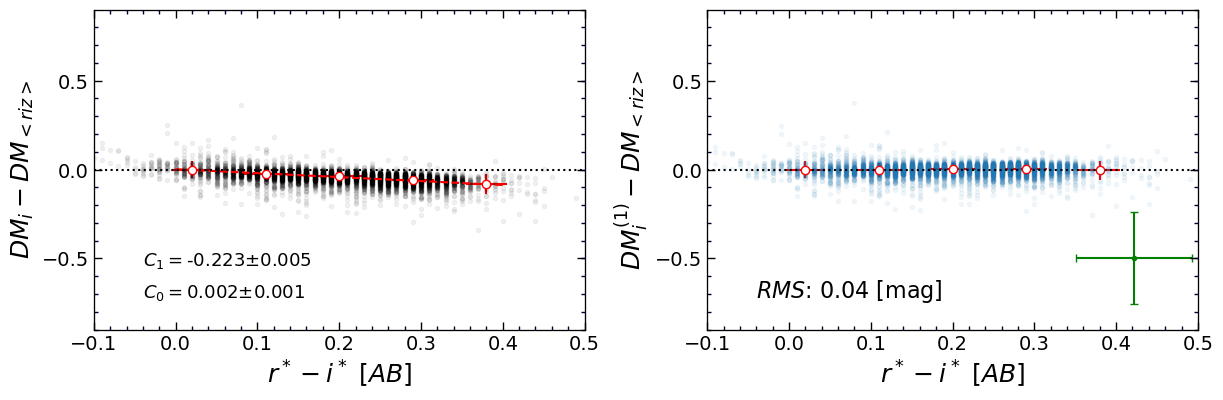

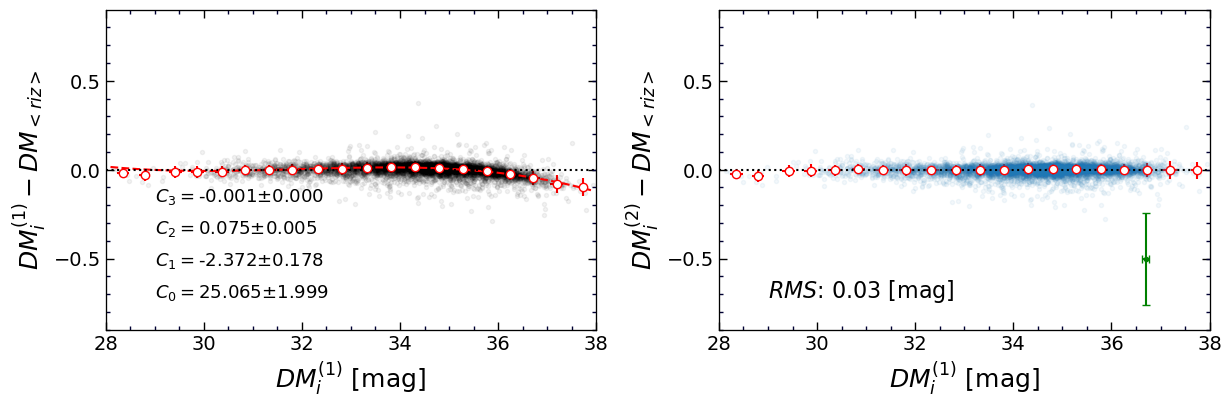

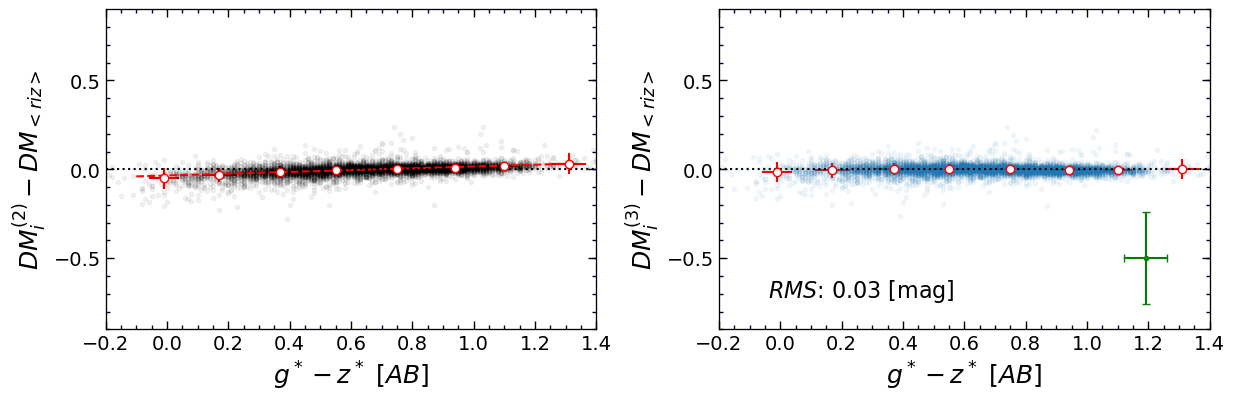

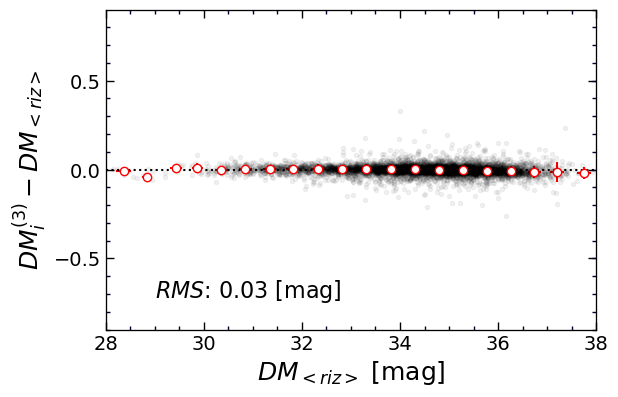

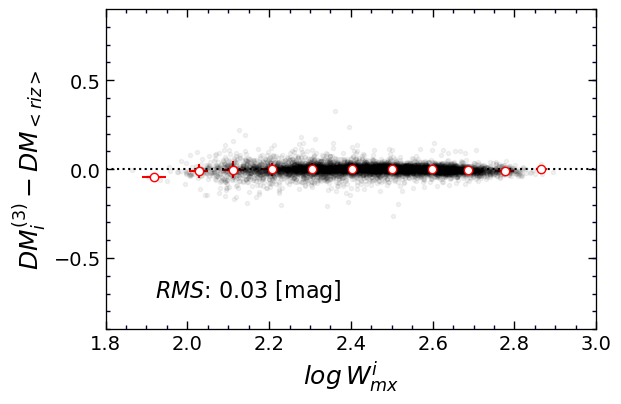

In [18]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1))

# DM_av = (DM_r+2*DM_i+2*DM_z)/5.
# dDM_av = np.sqrt(dDM_r**2+4*dDM_i**2+4*dDM_z**2)/5.
# DM_Bias_av = (DM_Bias_r+2*DM_Bias_i+2*DM_Bias_z)/5.


DM_av = (DM_r+DM_i+DM_z)/3.
dDM_av = np.sqrt(dDM_r**2+dDM_i**2+dDM_z**2)/3.
DM_Bias_av = (DM_Bias_r+DM_Bias_i+DM_Bias_z)/3.

axes, DM2i, fit, cov = adjustDM(DM_i, dDM_i, DM_av, dDM_av, r_i, 
                        xlim=(-0.1,0.5), indx=indx, quad=False,
                        xlabel=r'$r^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{i}', 
                        ylabelRef='DM_{<riz>}',
                        ylabel2='DM^{(1)}_{i}',       
                        bias1 = DM_Bias_i,
                        bias2 = DM_Bias_av,
                        dx=0.1, coeff=True
                        )


# axes, DM2i, fit, cov = adjustDM(DM2i, dDM_i, DM_av, dDM_av, g_i, 
#                         xlim=(-0.2,1.2), indx=indx, quad=False,
#                         xlabel=r'$g^*-i^* \/\/ [AB]$', 
#                         ylabelRef='DM_{<riz>}',
#                         ylabel='DM^{(1)}_{i}', 
#                         ylabel2='DM^{(2)}_{i}',       
#                         bias2 = DM_Bias_av
#                         )


# axes, DM2i, fit, cov = adjustDM(DM2i, dDM_i, DM_av, dDM_av, logWimx, 
#                         xlim=(1.8,3), indx=indx, quad=True,
#                         xlabel=r'$log \/ W^i_{mx}$', 
#                         ylabel='DM^{(2)}_{i}', 
#                         ylabel2='DM^{(3)}_{i}', 
#                         ylabelRef='DM_{<riz>}',
#                         dx=0.1, coeff=True,
#                         bias2 = DM_Bias_av
#                         )

axes, DM2i, fit, cov = adjustDM(DM2i, dDM_i, DM_av, dDM_av, DM2i, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM^{(1)}_{i}$'+' [mag]', deg3=True,
                        ylabel='DM^{(1)}_{i}', 
                        ylabel2='DM^{(2)}_{i}',
                        ylabelRef='DM_{< riz >}',
                        bias2 = DM_Bias_av,
                        dx=0.5, coeff=True,
                        )


axes, DM2i, fit, cov = adjustDM(DM2i, dDM_i, DM_av, dDM_av, g_z, 
                        xlim=(-0.2,1.4), indx=indx, quad=False,
                        xlabel=r'$g^*-z^* \/\/ [AB]$',  
                        ylabelRef='DM_{<riz>}',
                        ylabel='DM^{(2)}_{i}', 
                        ylabel2='DM^{(3)}_{i}',       
                        bias2 = DM_Bias_av
                        )


axes, _, fit, cov = adjustDM(DM2i, dDM_i, DM_av, dDM_av, DM_av+DM_Bias_av, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM_{< riz >}$'+' [mag]', 
                        ylabel='DM^{(3)}_{i}', 
                        ylabelRef='DM_{< riz >}',
                        dx = 0.5,
                        single=True,
                        scatter=True,
                        bias2 = DM_Bias_av,
                        )


axes, _, fit, cov = adjustDM(DM2i, dDM_i, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(3)}_{i}', 
                        ylabelRef='DM_{<riz>}',
                        dx=0.1, 
                        bias2 = DM_Bias_av,
                        single=True,
                        scatter=True
                        )

Fit params:
0.603\pm0.008
-0.058\pm0.002
Fit params:
0.352\pm0.021
-1.731\pm0.101
2.120\pm0.124
Fit params:
0.001\pm0.000
-0.105\pm0.005
3.327\pm0.185
-35.199\pm2.077
Fit params:
-0.071\pm0.012
0.249\pm0.057
-0.178\pm0.070
Fit params:
0.049\pm0.001
-0.033\pm0.001
Fit params:
0.000\pm0.000
-0.023\pm0.008
0.342\pm0.132
Fit params:
-0.012\pm0.010
0.000\pm0.049
0.074\pm0.059
Fit params:
-0.072\pm0.004
0.015\pm0.001


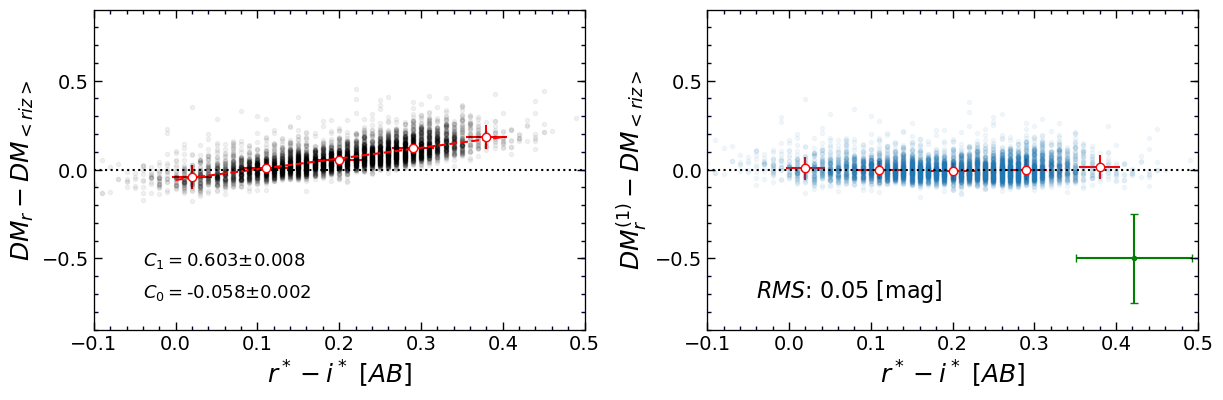

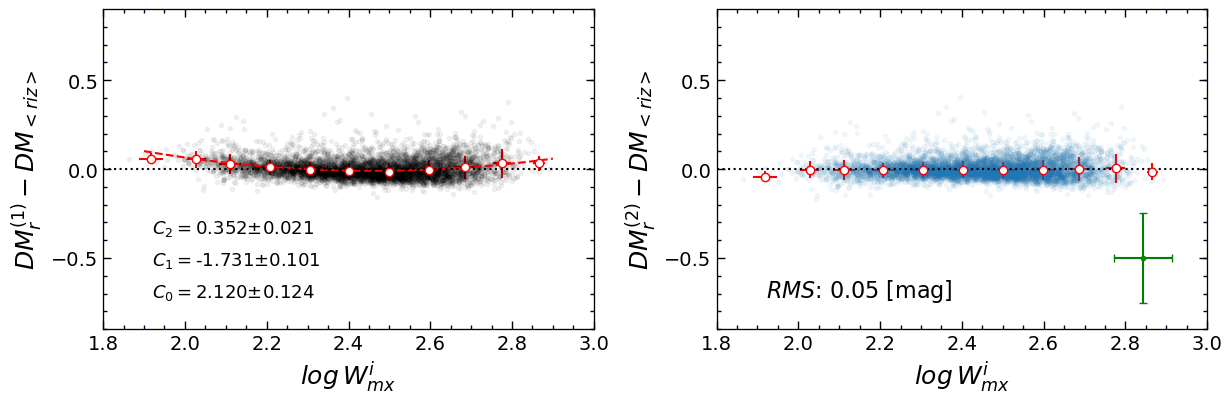

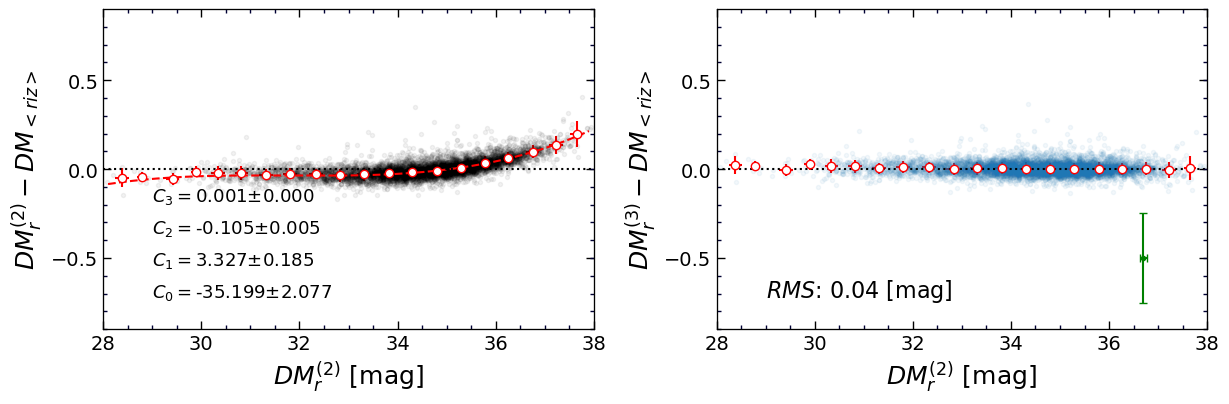

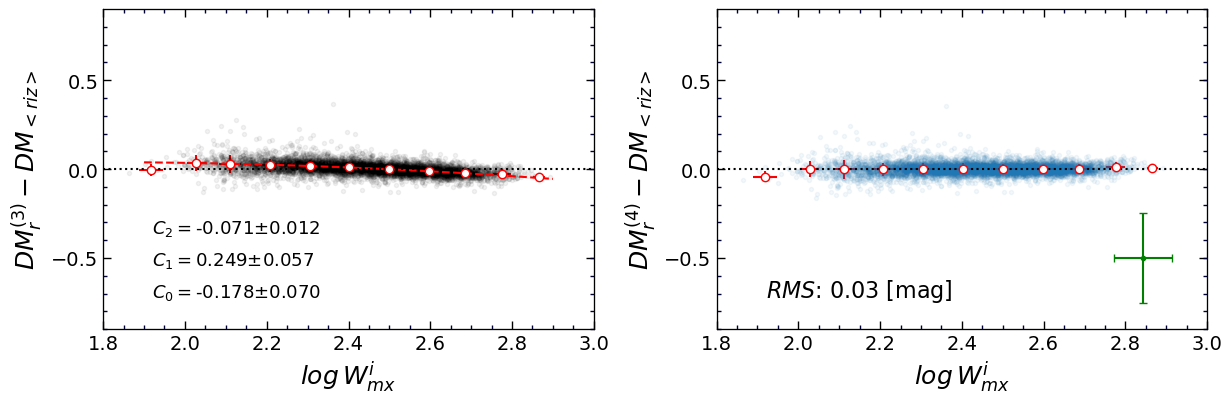

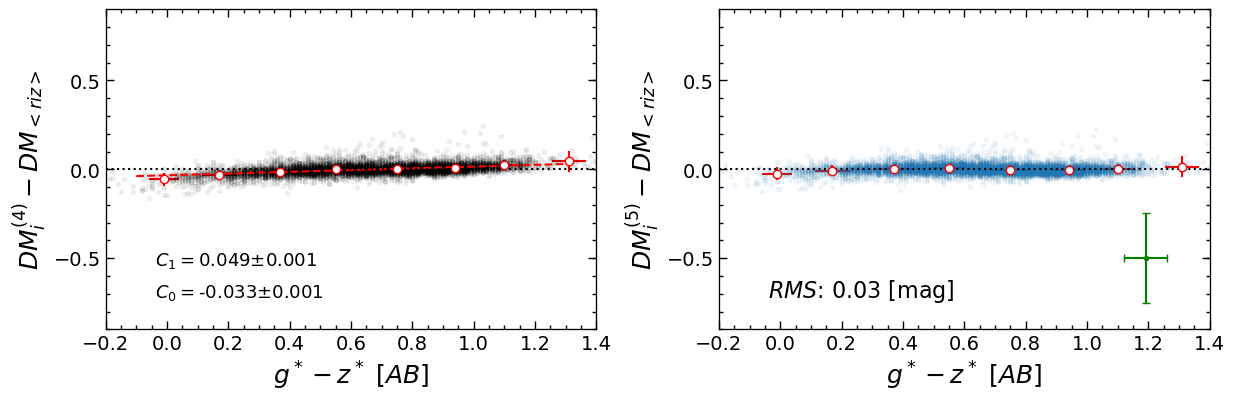

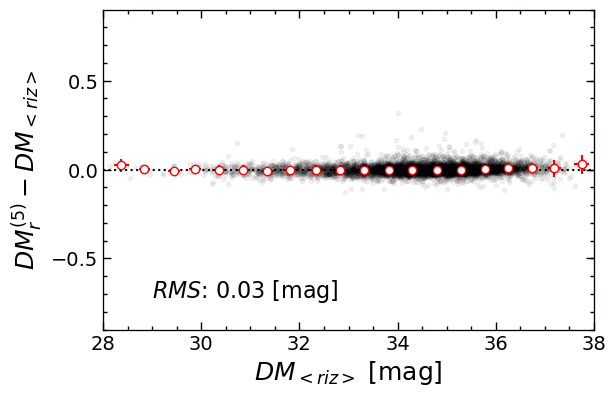

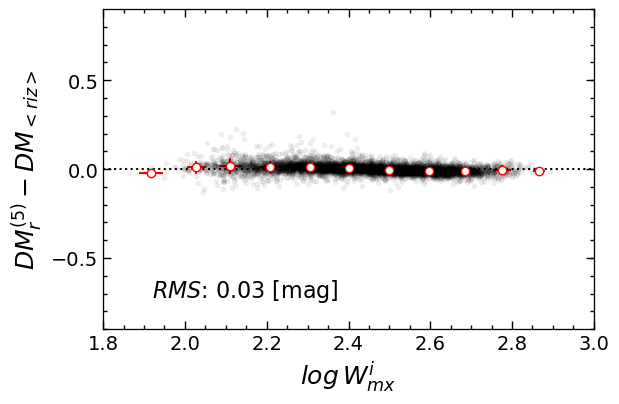

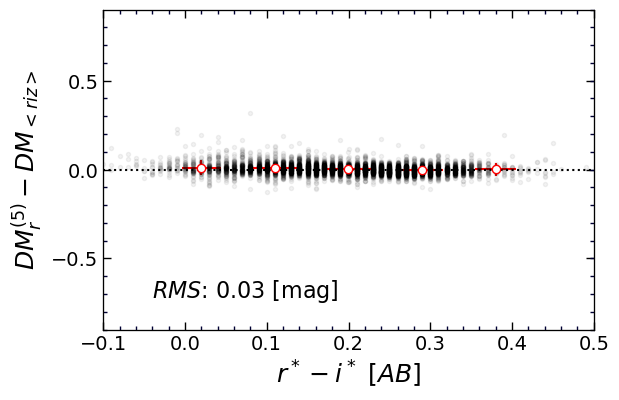

In [19]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1))

axes, DM2r, fit, cov = adjustDM(DM_r, dDM_r, DM_av, dDM_av, r_i, 
                        xlim=(-0.1,0.5), indx=indx, quad=False,
                        xlabel=r'$r^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{r}', 
                        ylabel2='DM^{(1)}_{r}',
                        ylabelRef='DM_{< riz >}',
                        bias1 = DM_Bias_r,
                        bias2 = DM_Bias_av,
                        dx=0.1, coeff=True
                        )


# axes, DM2r, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, g_i, 
#                         xlim=(-0.2,1.2), indx=indx, quad=False,
#                         xlabel=r'$g^*-i^* \/\/ [AB]$', 
#                         ylabel='DM^{(1)}_{r}', 
#                         ylabelRef='DM_{< riz >}',
#                         bias2 = DM_Bias_av,
#                         )


axes, DM2r, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(1)}_{r}', 
                        ylabel2='DM^{(2)}_{r}', 
                        ylabelRef='DM_{< riz >}',
                        dx=0.1, coeff=True,
                        bias2 = DM_Bias_av,
                        )

axes, DM2r, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, DM2r, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM^{(2)}_{r}$'+' [mag]', deg3=True,
                        ylabel='DM^{(2)}_{r}', 
                        ylabel2='DM^{(3)}_{r}',
                        ylabelRef='DM_{< riz >}',
                        dx=0.5, coeff=True,
                        bias2 = DM_Bias_av,
                        )

axes, DM2r, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(3)}_{r}', 
                        ylabel2='DM^{(4)}_{r}', 
                        ylabelRef='DM_{< riz >}',
                        dx=0.1, coeff=True,
                        bias2 = DM_Bias_av,
                        )

# axes, DM2r, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, g_z,
#                         xlim=(-0.2,1.4), indx=indx, quad=False,
#                         xlabel=r'$g^*-z^* \/\/ [AB]$', 
#                         ylabel='DM^{(3)}_{r}', 
#                         ylabel2='DM^{(4)}_{r}', 
#                         ylabelRef='DM_{< riz >}',
#                         dx=0.1, coeff=True,
#                         bias2 = DM_Bias_av,
#                         )


# axes, _, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, logWimx, 
#                         xlim=(1.8,3), indx=indx, quad=True,
#                         xlabel=r'$log \/ W^i_{mx}$', 
#                         ylabel='DM^{(4)}_{r}', 
#                         ylabelRef='DM_{< riz >}',
#                         single=True,
#                         scatter=True,
#                         bias2 = DM_Bias_av,
#                         )


axes, DM2r, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, g_z, 
                        xlim=(-0.2,1.4), indx=indx, quad=False,
                        xlabel=r'$g^*-z^* \/\/ [AB]$',  
                        ylabelRef='DM_{<riz>}',
                        ylabel='DM^{(4)}_{i}', 
                        ylabel2='DM^{(5)}_{i}',       
                        bias2 = DM_Bias_av, coeff=True,
                        )


axes, _, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, DM_av+DM_Bias_av, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM_{< riz >}$'+' [mag]', 
                        ylabel='DM^{(5)}_{r}', 
                        ylabelRef='DM_{< riz >}',
                        dx = 0.5,
                        single=True,
                        scatter=True,
                        bias2 = DM_Bias_av,
                        )



axes, _, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(5)}_{r}', 
                        ylabelRef='DM_{< riz >}',
                        dx=0.1, 
                        bias2 = DM_Bias_av,
                        single=True,
                        scatter=True
                        )



axes, _, fit, cov = adjustDM(DM2r, dDM_r, DM_av, dDM_av, r_i, 
                        xlim=(-0.1,0.5), indx=indx, quad=False,
                        xlabel=r'$r^*-i^* \/\/ [AB]$', 
                        ylabel='DM^{(5)}_{r}',
                        ylabelRef='DM_{< riz >}',
                        bias2 = DM_Bias_av,
                        dx=0.1, 
                        single=True,
                        scatter=True
                        )

Fit params:
-0.769\pm0.005
0.051\pm0.001
Fit params:
-0.308\pm0.011
1.491\pm0.054
-1.795\pm0.066
Fit params:
-0.001\pm0.000
0.054\pm0.004
-1.706\pm0.140
17.747\pm1.569
Fit params:
-0.000\pm0.000
0.005\pm0.007
-0.072\pm0.113
Fit params:
-0.014\pm0.001
0.009\pm0.001


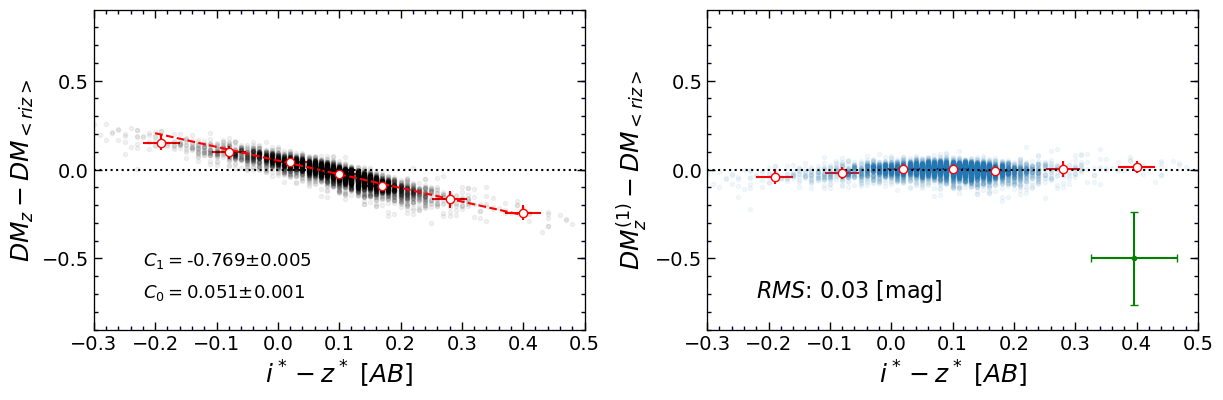

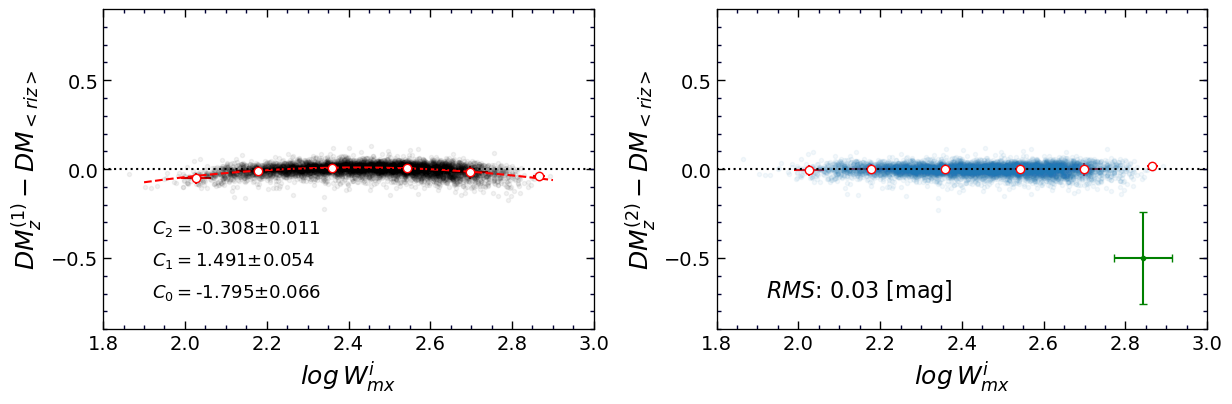

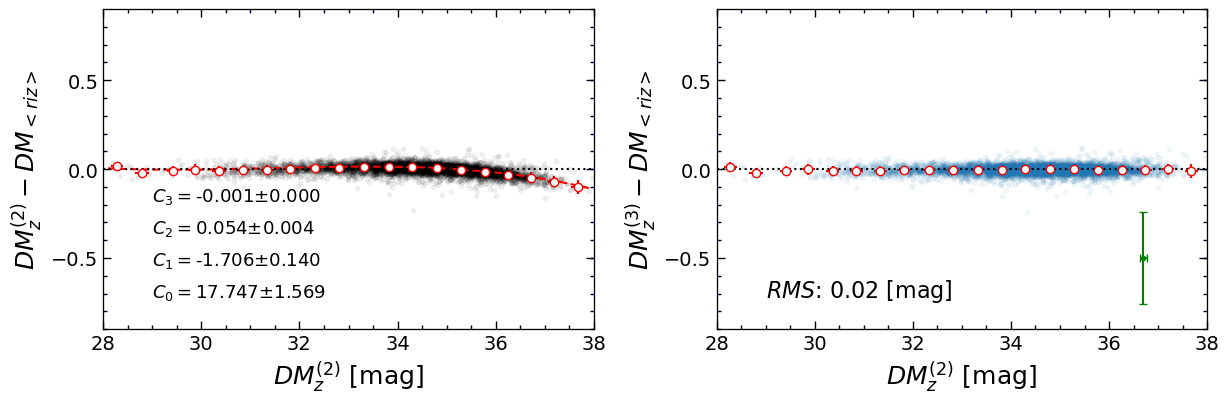

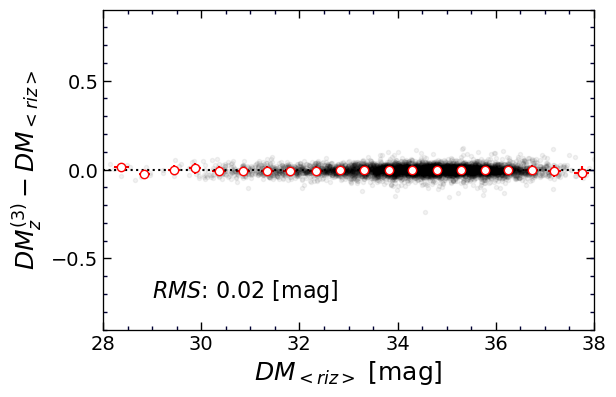

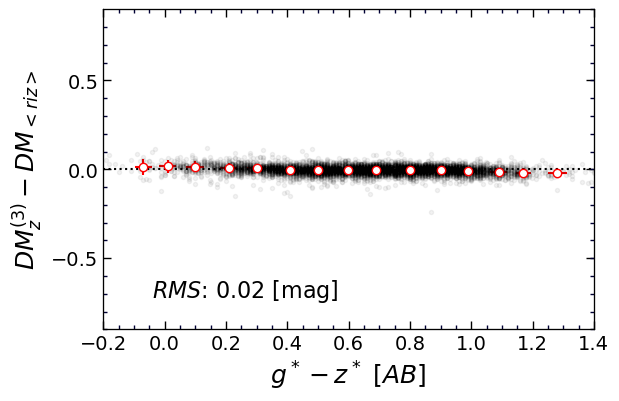

In [20]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1))

axes, DM2z, fit, cov = adjustDM(DM_z, dDM_z, DM_av, dDM_av, i_z, 
                        xlim=(-0.3,0.5), indx=indx, quad=False,
                        xlabel=r'$i^*-z^* \/\/ [AB]$', 
                        ylabel='DM_{z}', 
                        ylabel2='DM^{(1)}_{z}',
                        ylabelRef='DM_{< riz >}',
                        bias1 = DM_Bias_z,
                        bias2 = DM_Bias_av, coeff=True, dx=0.1
                        )


# axes, DM2z, fit, cov = adjustDM(DM2z, dDM_z, DM_av, dDM_av, g_r, 
#                         xlim=(-0.2,0.8), indx=indx, quad=False,
#                         xlabel=r'$g^*-r^* \/\/ [AB]$', 
#                         ylabel='DM_{1}', 
#                         ylabelRef='DM_{< riz >}',
#                         bias2 = DM_Bias_av, coeff=True
#                         )

axes, DM2z, fit, cov = adjustDM(DM2z, dDM_z, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(1)}_{z}', 
                        ylabel2='DM^{(2)}_{z}',
                        ylabelRef='DM_{< riz >}',
                        bias2 = DM_Bias_av, coeff=True
                        )

axes, DM2z, fit, cov = adjustDM(DM2z, dDM_z, DM_av, dDM_av, DM2z, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM^{(2)}_{z}$'+' [mag]', 
                        ylabel='DM^{(2)}_{z}', 
                        ylabel2='DM^{(3)}_{z}',
                        ylabelRef='DM_{< riz >}',
                        bias2 = DM_Bias_av,
                        dx = 0.5, deg3=True, coeff=True
                        )


# axes, DM2z, fit, cov = adjustDM(DM2z, dDM_z, DM_av, dDM_av, g_z, 
#                         xlim=(-0.2,1.4), indx=indx, quad=False,
#                         xlabel=r'$g^*-z^* \/\/ [AB]$',  
#                         ylabelRef='DM_{<riz>}',
#                         ylabel='DM^{(2)}_{z}', 
#                         ylabel2='DM^{(3)}_{z}',       
#                         bias2 = DM_Bias_av
#                         )



axes, _, fit, cov = adjustDM(DM2z, dDM_z, DM_av, dDM_av, DM_av+DM_Bias_av, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM_{< riz >}$'+' [mag]', 
                        ylabel='DM^{(3)}_{z}', 
                        ylabelRef='DM_{< riz >}',
                        bias2 = DM_Bias_av,
                        single=True, scatter=True, dx=0.5
                        )

axes, _, fit, cov = adjustDM(DM2z, dDM_z, DM_av, dDM_av, g_z, 
                        xlim=(-0.2,1.4), indx=indx, quad=False,
                        xlabel=r'$g^*-z^* \/\/ [AB]$',
                        ylabel='DM^{(3)}_{z}', 
                        ylabelRef='DM_{< riz >}',
                        bias2 = DM_Bias_av,
                        single=True, scatter=True, dx=0.1
                        )

In [21]:
cf3  = np.genfromtxt('cf3.csv' , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
pgc_cf3 = cf3['PGC']
DM_cf3  = cf3['DM']
eDM_cf3 = cf3['eDM']
N_cf3   = cf3['N']  
C_cf3   = cf3['C']  
F_cf3   = cf3['F']
I_cf3   = cf3['I']
S_cf3   = cf3['S']
H_cf3   = cf3['H']

Text(0.5,0,'$DM_{cf3}$')

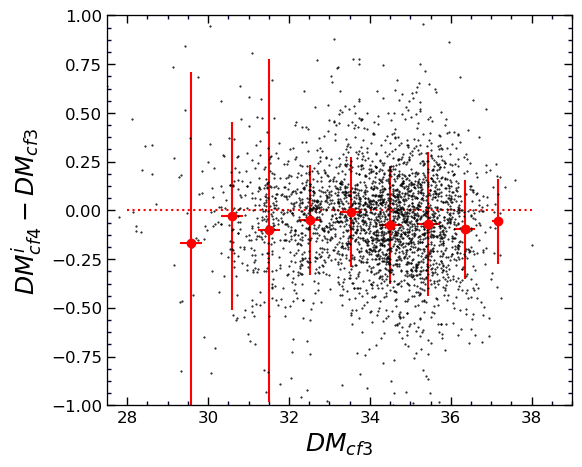

In [22]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


P = logWimx/logWimx_e
X = logWimx_e


Y = DM2i
indx = np.where(Sqlt==0)
Y[indx] = 0 



tmp = []

XX = []
YY = []
YYe = []
for i, id in enumerate(pgc_cf3):
    
    if id in pgc_tab:
        ix, = np.where(pgc_tab==id)
        if (ggg[ix][0]>0) & (rrr[ix][0]>0) & (iii[ix][0]>0) & (zzz[ix][0]>0) & (SSqlt[ix][0]>=3):
            
#                ax.errorbar(Vmod[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
               ax.errorbar(DM_cf3[i], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
               XX.append(DM_cf3[i])
               
               YYe.append(np.sqrt(dDM_z[ix][0]**2+eDM_cf3[i]**2))
               YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(29,38,1):
    xp = []
    yp = []
    ype = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(YY[ii])
            ype.append(YYe[ii])
    if len(xp)>0:
        xp  = np.asarray(xp)
        yp  = np.asarray(yp) 
        ype = np.asarray(ype)
        
        xp_av = np.sum(xp/ype)/np.sum(1./ype)
        yp_av = np.sum(yp/ype)/np.sum(1./ype)
        
        ax.errorbar(xp_av, yp_av, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6) 
        
ax.set_ylabel(r'$DM^i_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
# ax.plot([0,17500],[-3,3], 'r:')
# set_axes(ax, [0,17500],[0,0], fontsize=12)

set_axes(ax, [27.5,39],[-1,1], fontsize=12)
ax.plot([28,38],[0,0], 'r:')
ax.set_xlabel('$DM_{cf3}$', fontsize=18) 


Text(0.5,0,'$DM_{cf4}$')

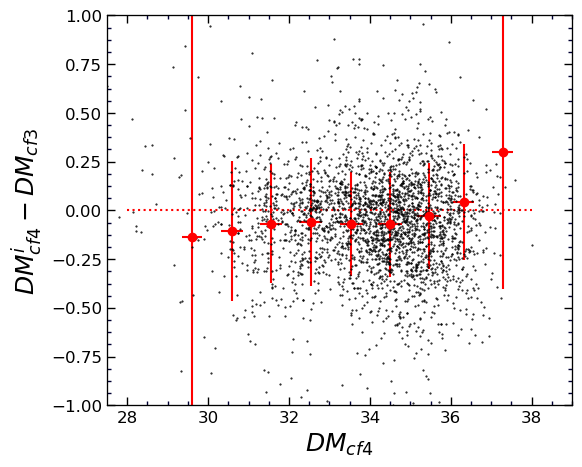

In [23]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


# esn_DM = (DM_i+DM_z_iz+DM_ggi_gi+DM_rgr_gr)/4. + bias
P = logWimx/logWimx_e
X = logWimx_e



Y = DM2i
indx = np.where(Sqlt==0)
Y[indx] = 0 



tmp = []

XX = []
YY = []
YYe = []
for i, id in enumerate(pgc_cf3):
    
    if id in pgc_tab:
        ix, = np.where(pgc_tab==id)
        if (ggg[ix][0]>0) & (rrr[ix][0]>0) & (iii[ix][0]>0) & (zzz[ix][0]>0) & (SSqlt[ix][0]>=3):
            
#                ax.errorbar(Vmod[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
               ax.errorbar(DM_cf3[i], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
               XX.append(Y[ix][0])
               YYe.append(np.sqrt(dDM_z[ix][0]**2+eDM_cf3[i]**2))
               YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(29,38,1):
    xp = []
    yp = []
    ype = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(YY[ii])
            ype.append(YYe[ii])
    if len(xp)>0:
        xp  = np.asarray(xp)
        yp  = np.asarray(yp) 
        ype = np.asarray(ype)
        
        xp_av = np.sum(xp/ype)/np.sum(1./ype)
        yp_av = np.sum(yp/ype)/np.sum(1./ype)
        
        ax.errorbar(xp_av, yp_av, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)               
            

ax.set_ylabel(r'$DM^i_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
set_axes(ax, [27.5,39],[-1,1], fontsize=12)
ax.plot([28,38],[0,0], 'r:')
ax.set_xlabel('$DM_{cf4}$', fontsize=18) 


-0.06084121115726776


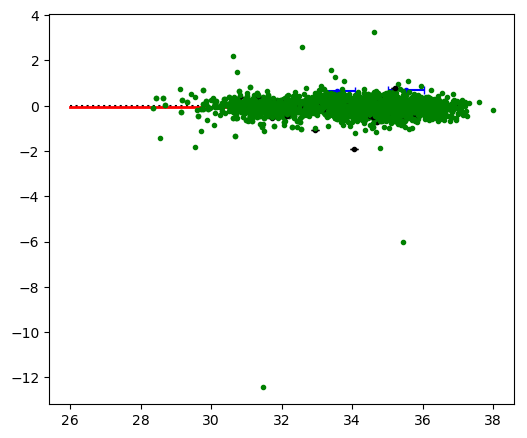

In [24]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


esn_DM = DM2i

tmp = []
for i, id in enumerate(pgc_cf3):
    
    if id in pgc_tab:
        ix, = np.where(pgc_tab==id)
        if (ggg[ix][0]>0) & (rrr[ix][0]>0) & (iii[ix][0]>0) & (zzz[ix][0]>0) & (SSqlt[ix][0]>=3):
            
            sig = np.sqrt(dDM_i[ix][0]**2+eDM_cf3[i]**2)*0
            
            if N_cf3[i]=='N':
                ax.errorbar(DM_cf3[i], DM_i[ix][0]- DM_cf3[i], yerr=sig, capsize=3, color='k', fmt='.' )
                tmp.append(esn_DM[ix][0]- DM_cf3[i])  
            
#             if C_cf3[i]=='C':
#                 ax.errorbar(DM_cf3[i], DM_i[ix][0]- DM_cf3[i], xerr=eDM_cf3[i], yerr=sig, capsize=3, color='r', fmt='.' )
                             
            
            if F_cf3[i]=='F':
                ax.errorbar(DM_cf3[i], DM_i[ix][0]- DM_cf3[i], xerr=eDM_cf3[i], yerr=sig, capsize=3, color='b', fmt='.' )
                
            if I_cf3[i]=='I':
                ax.errorbar(DM_cf3[i], esn_DM[ix][0]- DM_cf3[i], xerr=eDM_cf3[i]*0, yerr=sig, capsize=0, color='g', fmt='.' )
                tmp.append(esn_DM[ix][0]- DM_cf3[i])  
                
            if H_cf3[i]=='H':
                ax.errorbar(DM_cf3[i], esn_DM[ix][0]- DM_cf3[i], xerr=eDM_cf3[i]*0, yerr=sig, capsize=0, color='g', fmt='.' )
                tmp.append(esn_DM[ix][0]- DM_cf3[i])  
                                                
#             if S_cf3[i]=='S':
#                 ax.errorbar(DM_cf3[i], DM_i[ix][0]- DM_cf3[i], xerr=eDM_cf3[i], yerr=sig, capsize=3, color='purple', fmt='.' )
                                                
            
ax.plot([26,37],[0,0], 'k:')


med = np.mean(tmp)
ax.plot([26,37],[med, med], 'r-',lw=2)
print med


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


1858
Fit params:
-0.283\pm0.018
-0.980\pm0.018
-0.446\pm0.005


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in add


Fit params:
0.001\pm0.001
-0.008\pm0.002
-0.106\pm0.004
-0.033\pm0.005
Fit params:
5.707\pm0.623
-41.618\pm4.626
101.063\pm11.424
-81.745\pm9.382
Fit params:
-0.003\pm0.001
0.199\pm0.086
-3.297\pm1.436
Fit params:
-0.383\pm0.011
-0.189\pm0.006


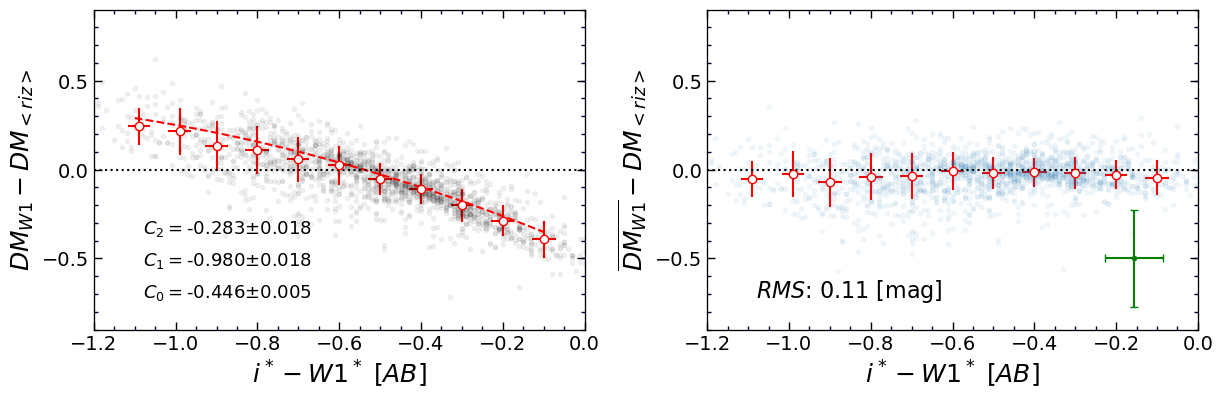

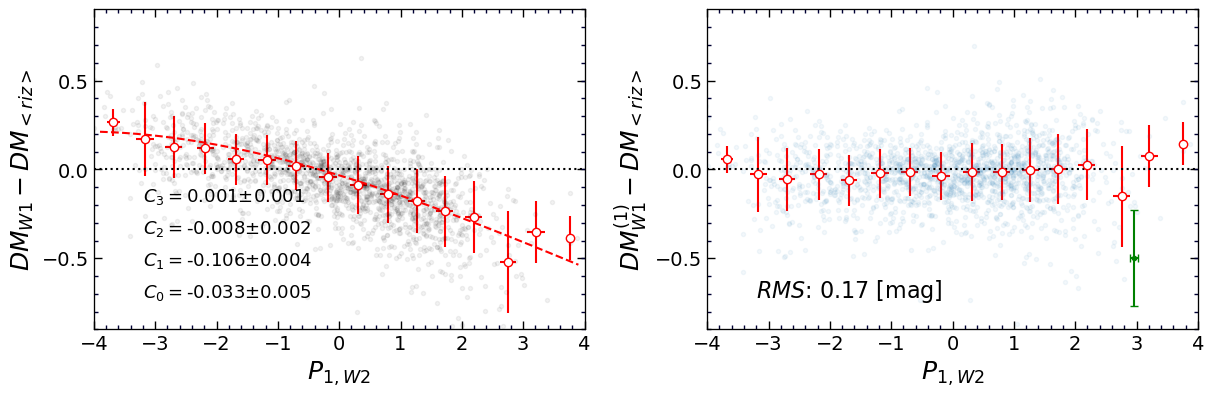

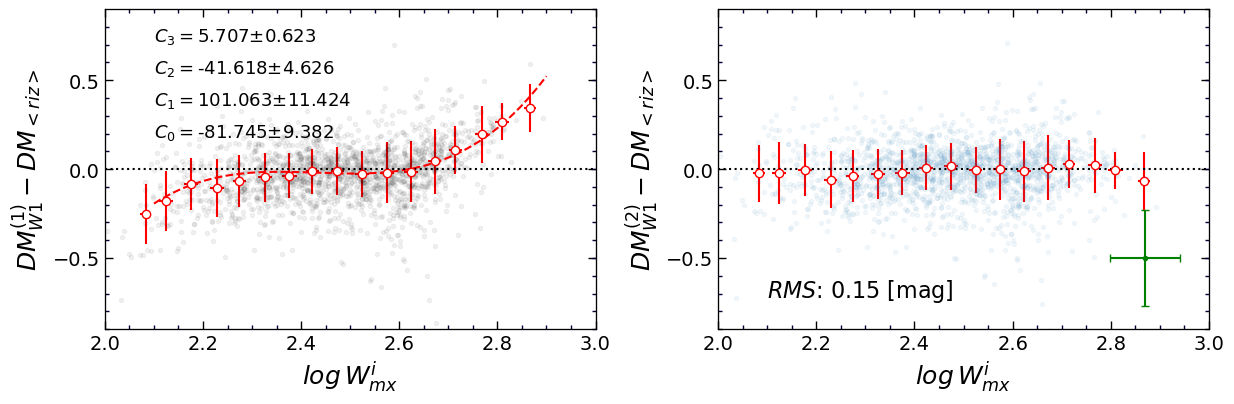

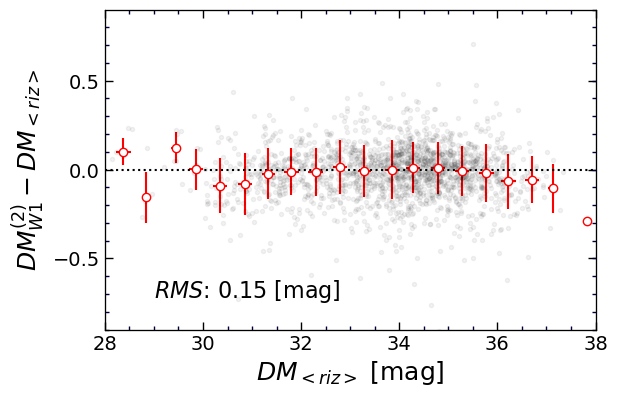

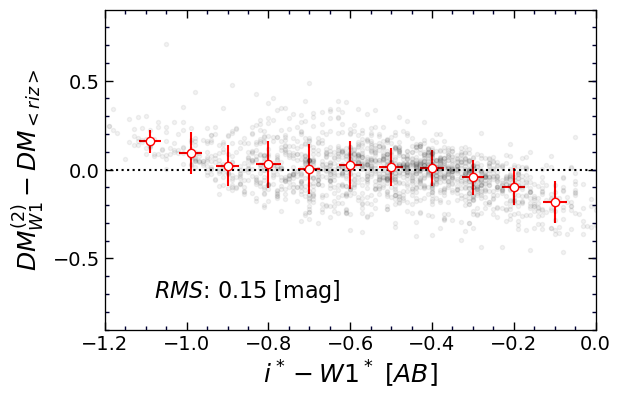

In [25]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1) & (WWqlt>3) & 
                 (w22>0) & (w11>0) & (RS==2))

print len(indx)
axes, _, fit, cov = adjustDM(DM_1, dDM_1 , DM_av, dDM_av, iii-w11, 
                        xlim=(-1.2,0), indx=indx, quad=True, single=False,
                        xlabel=r'$i^*-W1^* \/\/ [AB]$', 
                        ylabel='DM_{W1}', 
                        ylabel2='\overline{DM_{W1}}',
                        ylabelRef='DM_{< riz >}',
                        bias1 = DM_Bias_w1,
                        bias2 = DM_Bias_av,
                        dx = 0.1, coeff=True
                        )


axes, DMw1, fit, cov = adjustDM(DM_1, dDM_1, DM_av, dDM_av, P0, 
                        xlim=(-4,4), indx=indx, quad=True,
                        xlabel=r'$P_{1,W2}$', 
                        ylabel='DM_{W1}', 
                        ylabel2='DM^{(1)}_{W1}', 
                        ylabelRef='DM_{< riz >}',
                        bias1 = DM_Bias_w1,
                        bias2 = DM_Bias_av, 
                        dx=0.5, coeff=True, deg3=True
                        )



############## Never Uncomment for business
axes, DMw1, fit, cov = adjustDM(DMw1, dDM_1, DM_av, dDM_av, logWimx, 
                        xlim=(2,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(1)}_{W1}', 
                        ylabel2='DM^{(2)}_{W1}', 
                        ylabelRef='DM_{< riz >}',
                        dx = 0.05, deg3=True,        
                        bias2 = DM_Bias_av, 
                        coeff=True, rev=True
                        )


# axes, DMw1, fit, cov = adjustDM(DMw1, dDM_1, DM_av, dDM_av, mu50_w1, 
#                         xlim=(21,26), indx=indx, quad=True,
#                         xlabel=r'$\mu50$', 
#                         ylabel='C(DM_{W1})', 
#                         bias2 = DM_Bias_av
#                         )



# axes, DMw1, fit, cov = adjustDM(DMw1, dDM_1, DM_av, dDM_av, logWimx, 
#                         xlim=(2,3), indx=indx, quad=True,
#                         xlabel=r'$log \/ W^i_{mx}$', 
#                         ylabel='DM_{?}',
#                         dx = 0.05, deg3=True,
#                         bias2 = DM_Bias_av, 
#                         )


# axes, DMw1, fit, cov = adjustDM(DMw1, dDM_1, DM_av, dDM_av, DMw1, 
#                         xlim=(28,38), indx=indx, quad=True,
#                         xlabel=r'$DM_i$'+' [mag]', 
#                         ylabel='DM^{(2)}_{W1}', 
#                         bias2 = DM_Bias_av,
#                         dx=0.5, scatter=True, 
#                         )


axes, _, fit, cov = adjustDM(DMw1, dDM_1, DM_av, dDM_av, DM_av+DM_Bias_av, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM_{< riz >}$'+' [mag]', 
                        ylabel='DM^{(2)}_{W1}', 
                        ylabelRef='DM_{< riz >}',
                        bias2 = DM_Bias_av,
                        single=True, dx=0.5, scatter=True
                        )
#####################

axes, _, fit, cov = adjustDM(DMw1, dDM_1, DM_av, dDM_av, iii-w11,
                        xlim=(-1.2,0), indx=indx, quad=False,
                        xlabel=r'$i^*-W1^* \/\/ [AB]$', 
                        ylabel='DM^{(2)}_{W1}', 
                        ylabelRef='DM_{< riz >}',
                        single=True,
                        bias2 = DM_Bias_av,
                        dx=0.1, scatter=True
                        )

Fit params:
0.014\pm0.002
-0.448\pm0.084


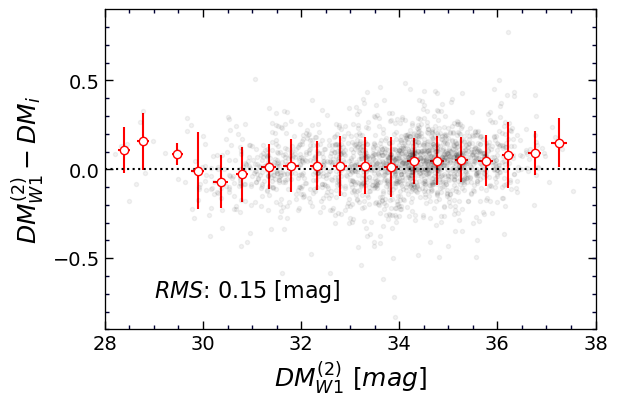

In [26]:
axes, _, fit, cov = adjustDM(DMw1, dDM_1, DM_i, dDM_i, DMw1,
                        xlim=(28,38), indx=indx, quad=False,
                        xlabel=r'$DM^{(2)}_{W1} \/\/[mag]$', 
                        ylabel='DM^{(2)}_{W1}', single=True,
                        bias2 = DM_Bias_i,
                        dx=0.5, scatter=True
                        )

Fit params:
-0.000\pm0.000
-0.001\pm0.008


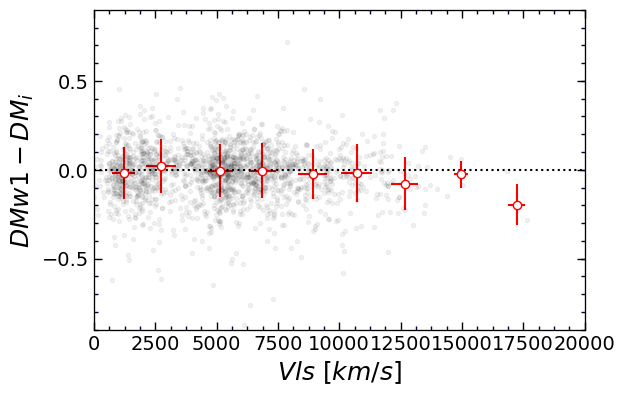

In [27]:
axes, _, fit, cov = adjustDM(DMw1, dDM_1, DM2i, dDM_i, Vls,
                        xlim=(0,20000), indx=indx, quad=False,
                        xlabel=r'$Vls \/\/ [km/s]$', 
                        ylabel='DMw1', single=True,
                        dx=2000
                        )

1164.0 -0.07661261103972805
2657.0 -0.02590731252548295
5079.5 -0.04584947843131815
6869.0 -0.036873497538625344
9091.0 -0.05663723750245708
10639.0 -0.05388107828339628
12696.0 -0.06842221504410873
14982.0 0.0881962610094078
16941.0 -0.455767250851288
-0.04998513696643769


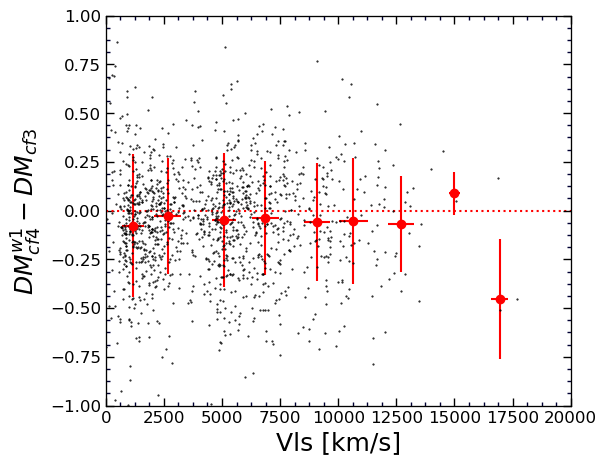

In [28]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


# esn_DM = (DM_i+DM_z_iz+DM_ggi_gi+DM_rgr_gr)/4. + bias
P = logWimx/logWimx_e
X = logWimx_e



# Y = DM_i + 1.0*DM_Bias_i
Y = DMw1
indx = np.where(Wqlt==0)
Y[indx] = 0 



tmp = []

XX = []
YY = []
YYe = []
for i, id in enumerate(pgc_cf3):
    
    if id in pgc_tab:
        ix, = np.where(pgc_tab==id)
#         if (ggg[ix][0]>0) & (rrr[ix][0]>0) & (iii[ix][0]>0) & (zzz[ix][0]>0) & (SSqlt[ix][0]>=3):
        if (w11[ix][0]>0) & (WWqlt[ix][0]>=3) & (SSqlt[ix][0]>=3):
            
               ax.errorbar(Vls[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
               XX.append(Vls[ix][0])
               YYe.append(np.sqrt(dDM_1[ix][0]**2+eDM_cf3[i]**2))
               YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(0,20000,2000):
    xp = []
    yp = []
    ype = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(YY[ii])
            ype.append(YYe[ii])
    if len(xp)>0:
        xp  = np.asarray(xp)
        yp  = np.asarray(yp) 
        ype = np.asarray(ype)
        
        xp_av = np.sum(xp/ype)/np.sum(1./ype)
        yp_av = np.sum(yp/ype)/np.sum(1./ype)
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)    
        print np.median(xp), np.median(yp)
    

ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$DM^{w1}_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
ax.plot([0,20000],[0,0], 'r:')
set_axes(ax, [0,20000],[-1,1], fontsize=12)

print np.median(YY)

In [29]:
N = len(table['pgc'])

indx = np.where(Sqlt==0)

DM2r[indx] = 0
dDM_r[indx] = 0
DM2i[indx] = 0
DM_i[indx] = 0
dDM_i[indx] = 0
DM_z[indx] = 0
DM2z[indx] = 0
dDM_z[indx] = 0


P = logWimx/logWimx_e
X = logWimx_e


######################################################################


Y = DM2r

med = 1.8699717152765654
c = [-8.91753848e-03,  1.57901951e-03,  1.86956149e+00]
Y = Y + 5.*(c[0]*P0**2+c[1]*P0+c[2]) - 5.*med

med = 1.8732150505089085
c   = [7.49005252, 1.00974275, 1.85202354]
Y[X<0.1] = Y[X<0.1] + 5.*(c[0]*X[X<0.1]**2+c[1]*X[X<0.1]+c[2]) - 5.*med

W = [-0.11359678,  2.15652166]
Y = Y  + 5.*(W[0]*logWimx+W[1]) - 5.*med


Mag_r = rrr-DM_r
rms_a, rms_b, rms_c =  -0.04358023,  -1.63809007, -14.8307324  # r
rms_r = myCurve(Mag_r, rms_a, rms_b, rms_c)

m = [ 0.01011565, -0.34466599]
Y = Y - (m[0]*Y+m[1])

indx = np.where((P0>8) | (P0<-8))
Y[indx] = DM2r[indx]

indx = np.where((Sqlt==0) | (rrr<=0))
Y[indx] = 0 
rrr[indx] = 0
dDM_r[indx] = 0
rms_r[indx] = 0
DM_r[indx] = 0

DMr_mod = copy.deepcopy(Y)


######################################################################


Y = DM2i 

med = 1.8665042327011725
c = [-8.92953705e-03,  7.34327916e-04,  1.86791905e+00]
Y = Y + 5.*(c[0]*P0**2+c[1]*P0+c[2]) - 5.*med

med = 1.87012038784693
c   = [6.45277122, 1.16773991, 1.84640334]
Y[X<0.1] = Y[X<0.1] + 5.*(c[0]*X[X<0.1]**2+c[1]*X[X<0.1]+c[2]) - 5.*med

W = [-0.1194727,  2.1681067]
Y = Y  + 5.*(W[0]*logWimx+W[1]) - 5.*med

Y -= 0.01

Mag_i = iii-DM_i
rms_a, rms_b, rms_c =  -0.0277935,  -1.01618513, -8.68936204   # i 
rms_i = myCurve(Mag_i, rms_a, rms_b, rms_c)


yi = DM_i + DM_Bias_i
indx = np.where((P0>8) | (P0<-8))
Y[indx] = yi[indx]

indx = np.where((Sqlt==0) | (iii<=0))
Y[indx] = 0 
iii[indx] = 0
dDM_i[indx] = 0
rms_i[indx] = 0
DM_i[indx] = 0

DMi_mod = copy.deepcopy(Y)

######################################################################

Y = DM2z

med = 1.864635758310733
c = [-8.89877869e-03, -3.74245319e-04,  1.86730364e+00]
Y = Y + 5.*(c[0]*P0**2+c[1]*P0+c[2]) - 5.*med

med = 1.868719566150012
c   = [2.5104679,  1.36700778, 1.84279445]
Y[X<0.1] = Y[X<0.1] + 5.*(c[0]*X[X<0.1]**2+c[1]*X[X<0.1]+c[2]) - 5.*med

W = [-0.12427396,  2.1789558 ]
Y = Y  + 5.*(W[0]*logWimx+W[1]) - 5.*med

Y -= 0.02

Mag_z = zzz-DM_z
rms_a, rms_b, rms_c =  -0.02873967, -1.05875529, -9.15734311   # z 
rms_z = myCurve(Mag_z, rms_a, rms_b, rms_c)

indx = np.where((P0>8) | (P0<-8))
Y[indx] = DM2z[indx]

indx = np.where((Sqlt==0) | (zzz<=0))
Y[indx] = 0 
zzz[indx] = 0
dDM_z[indx] = 0
rms_z[indx] = 0
DM_z[indx] = 0

DMz_mod = copy.deepcopy(Y)

######################################################################

Y = DMw1

#############################################################

med = 1.8700239727707284

c = [-4.86963586e-03,  9.08179640e-04,  1.87356725e+00]
Y = Y + 5.*(c[0]*P0**2+c[1]*P0+c[2]) - 5.*med

# med = 1.8741371602507384
c   = [44.71627745, -0.75953338,  1.86685215]
Y[X<0.1] = Y[X<0.1] + 5.*(c[0]*X[X<0.1]**2+c[1]*X[X<0.1]+c[2]) - 5.*med


# ################# Post post

W = [0.00886167, 0.02982851, 0.03974232]
Y = Y - (W[0]*P0**2+W[1]*P0+W[2])

Y = Y + 0.01


###################################################

Mag_1 = w11-DM_1
rms_a, rms_b, rms_c =  -0.01488638, -0.52343314, -3.94385739   # w1
rms_w1 = myCurve(Mag_1, rms_a, rms_b, rms_c)

indx = np.where((P0>8) | (P0<-8))
Y[indx] = DMw1[indx]

indx = np.where((Wqlt==0) | (w11<=0))
Y[indx] = 0 
dDM_1[indx] = 0
rms_w1[indx] = 0
DM_1[indx] = 0

DMw1_mod = copy.deepcopy(Y) 


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in add
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in add
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in add
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in less_equal


In [30]:
def fmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2

    return fmod

In [31]:
table_tmp = np.genfromtxt('Hriz_3sigClip.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop_riz = table_tmp['PGC']

table_tmp = np.genfromtxt('Hw1_3sigClip.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop_w1 = table_tmp['PGC']

print len(pgc_drop_riz)
print len(pgc_drop_w1)

extraDrops = np.asarray([25376, 54262, 1798333])

pgc_drop_riz = np.concatenate((pgc_drop_riz,extraDrops))
pgc_drop_w1  = np.concatenate((pgc_drop_w1,extraDrops))
##########################################################
keep_riz = pgc_tab*0.
p = 0
for i, idd in enumerate(pgc_tab):
    if not idd in pgc_drop_riz:
        keep_riz[i] = 1
    else:
        p+=1
print "Total numner of dropped riz:", p
##########################################################
keep_w1 = pgc_tab*0.
p = 0
for i, idd in enumerate(pgc_tab):
    if not idd in pgc_drop_w1:
        keep_w1[i] = 1
    else:
        p+=1
print "Total numner of dropped W1:", p
##########################################################

10
17
Total numner of dropped riz: 12
Total numner of dropped W1: 18


In [32]:
myTable = Table()

myTable.add_column(Column(data=pgc_tab, name='pgc'))
myTable.add_column(Column(data=Vhel, name='Vh', dtype=np.dtype(int)))
myTable.add_column(Column(data=Vls, name='Vls', dtype=np.dtype(int)))
myTable.add_column(Column(data=V3k, name='V3k', dtype=np.dtype(int)))
myTable.add_column(Column(data=Vmod, name='Vmod', dtype=np.dtype(int)))


f_cosmology = fmod(V3k)
myTable.add_column(Column(data=f_cosmology, name='f_cosmology', format='%0.3f'))


myTable.add_column(Column(data=logWimx, name='logWimx', format='%0.3f'))
myTable.add_column(Column(data=logWimx_e, name='logWimx_e', format='%0.3f'))
myTable.add_column(Column(data=inc, name='inc', dtype=np.dtype(int)))
myTable.add_column(Column(data=table['Sqlt'], name='Sqlt', dtype=np.dtype(int)))
myTable.add_column(Column(data=table['Wqlt'], name='Wqlt', dtype=np.dtype(int)))

######################################################################

DM_best = DMr_mod*0
dDM_best = DMr_mod*0
DM_src = DMr_mod*0

for j in range(len(DMz_mod)):
    
    idd = pgc_tab[j]
    if DMr_mod[j]>0 and DMi_mod[j]>0 and DMz_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = (DMr_mod[j]+DMi_mod[j]+DMz_mod[j])/3.
        dDM_best[j] = np.median([dDM_r[j],dDM_i[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and DMi_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = (DMr_mod[j]+DMi_mod[j])/2.
        dDM_best[j] = np.median([dDM_r[j],dDM_i[j]])
        DM_src[j] = 1
    elif DMz_mod[j]>0 and DMi_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = (DMz_mod[j]+DMi_mod[j])/2.
        dDM_best[j] = np.median([dDM_i[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and DMz_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = (DMr_mod[j]+DMz_mod[j])/2.      
        dDM_best[j] = np.median([dDM_r[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = DMr_mod[j]
        dDM_best[j] = dDM_r[j]
        DM_src[j] = 1
    elif DMi_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = DMi_mod[j]
        dDM_best[j] = dDM_i[j]
        DM_src[j] = 1
    elif DMz_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = DMz_mod[j]
        dDM_best[j] = dDM_z[j]
        DM_src[j] = 1
    elif DMw1_mod[j]>0 and not idd in pgc_drop_w1:
        DM_best[j] = DMw1_mod[j]
        dDM_best[j] = dDM_1[j]
        DM_src[j] = 2
##################################
    elif DMr_mod[j]>0 and DMi_mod[j]>0 and DMz_mod[j]>0:
        DM_best[j] = (DMr_mod[j]+DMi_mod[j]+DMz_mod[j])/3.
        dDM_best[j] = np.median([dDM_r[j],dDM_i[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and DMi_mod[j]>0:
        DM_best[j] = (DMr_mod[j]+DMi_mod[j])/2.
        dDM_best[j] = np.median([dDM_r[j],dDM_i[j]])
        DM_src[j] = 1
    elif DMz_mod[j]>0 and DMi_mod[j]>0:
        DM_best[j] = (DMz_mod[j]+DMi_mod[j])/2.
        dDM_best[j] = np.median([dDM_i[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and DMz_mod[j]>0:
        DM_best[j] = (DMr_mod[j]+DMz_mod[j])/2.      
        dDM_best[j] = np.median([dDM_r[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0:
        DM_best[j] = DMr_mod[j]
        dDM_best[j] = dDM_r[j]
        DM_src[j] = 1
    elif DMi_mod[j]>0:
        DM_best[j] = DMi_mod[j]
        dDM_best[j] = dDM_i[j]
        DM_src[j] = 1
    elif DMz_mod[j]>0:
        DM_best[j] = DMz_mod[j]
        dDM_best[j] = dDM_z[j]
        DM_src[j] = 1
    elif DMw1_mod[j]>0:
        DM_best[j] = DMw1_mod[j]
        dDM_best[j] = dDM_1[j]
        DM_src[j] = 2
    if idd in extraDrops:
        DM_best[j] = 0
        dDM_best[j] = 0
        DM_src[j] = 0         
            
    
myTable.add_column(Column(data=DM_best, name='DM_best', format='%0.2f'))
myTable.add_column(Column(data=dDM_best, name='dDM_best', format='%0.2f'))

######################################################################

myTable.add_column(Column(data=DMr_mod, name='DMr', format='%0.2f'))
myTable.add_column(Column(data=dDM_r, name='dDMr', format='%0.2f'))
myTable.add_column(Column(data=rms_r, name='RMS_r', format='%0.2f'))
myTable.add_column(Column(data=DM_r, name='DMr_raw', format='%0.2f'))

myTable.add_column(Column(data=DMi_mod, name='DMi', format='%0.2f'))
myTable.add_column(Column(data=dDM_i, name='dDMi', format='%0.2f'))
myTable.add_column(Column(data=rms_i, name='RMS_i', format='%0.2f'))
myTable.add_column(Column(data=DM_i, name='DMi_raw', format='%0.2f'))

myTable.add_column(Column(data=DMz_mod, name='DMz', format='%0.2f'))
myTable.add_column(Column(data=dDM_z, name='dDMz', format='%0.2f'))
myTable.add_column(Column(data=rms_z, name='RMS_z', format='%0.2f'))
myTable.add_column(Column(data=DM_z, name='DMz_raw', format='%0.2f'))

myTable.add_column(Column(data=DMw1_mod, name='DM_w1', format='%0.2f'))
myTable.add_column(Column(data=dDM_1, name='dDM_w1', format='%0.2f'))
myTable.add_column(Column(data=rms_w1, name='RMS_w1', format='%0.2f'))
myTable.add_column(Column(data=DM_1, name='DMw1_raw', format='%0.2f'))


myTable.add_column(Column(data=ggg, name='ggg', format='%0.2f'))
myTable.add_column(Column(data=rrr, name='rrr', format='%0.2f'))
myTable.add_column(Column(data=iii, name='iii', format='%0.2f'))
myTable.add_column(Column(data=zzz, name='zzz', format='%0.2f'))
myTable.add_column(Column(data=w11, name='w1', format='%0.2f'))
myTable.add_column(Column(data=w22, name='w2', format='%0.2f'))
myTable.add_column(Column(data=ra, name='RA', format='%0.4f'))
myTable.add_column(Column(data=dec, name='DEC', format='%0.4f'))
myTable.add_column(Column(data=gl, name='gl', format='%0.4f'))
myTable.add_column(Column(data=gb, name='gb', format='%0.4f'))
myTable.add_column(Column(data=sgl, name='sgl', format='%0.4f'))
myTable.add_column(Column(data=sgb, name='sgb', format='%0.4f'))
myTable.add_column(Column(data=pgc1, name='pgc1', dtype=np.dtype(int)))
myTable.add_column(Column(data=nest, name='Nest', dtype=np.dtype(int)))
myTable.add_column(Column(data=Vmodg, name='Vmodg', dtype=np.dtype(int)))
myTable.add_column(Column(data=Nkt, name='Nkt', dtype=np.dtype(int)))
myTable.add_column(Column(data=N15, name='N15', dtype=np.dtype(int)))
myTable.add_column(Column(data=sglg, name='sglg', format='%0.4f'))
myTable.add_column(Column(data=sgbg, name='sgbg', format='%0.4f'))
myTable.add_column(Column(data=RS, name='RS'))
myTable.add_column(Column(data=P0, name='P0'))
myTable.add_column(Column(data=DM_src, name='DM_src', dtype=np.dtype(int)))

myTable.write('DMs_EDD.csv.test', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

Text(0,0.5,'No. of galaxies')

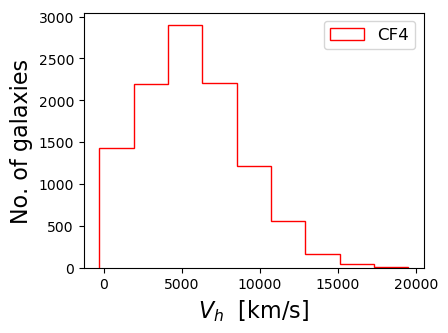

In [33]:
Vhel_tab = table['Vhel']




fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
                  
ax.hist(Vhel_tab, bins=9, histtype='step', label='CF4', color='red')

ax.legend(prop={'size': 12})

ax.set_xlabel(r'$V_h$'+'  [km/s]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)




Fit params:
-0.005\pm0.001
0.003\pm0.000
Fit params:
0.000\pm0.000
-0.007\pm0.001
0.246\pm0.048
-2.915\pm0.536
Fit params:
0.009\pm0.000
-0.006\pm0.000
Fit params:
-0.000\pm0.000
0.002\pm0.002
-0.030\pm0.039
Fit params:
-0.079\pm0.003
0.384\pm0.014
-0.467\pm0.017


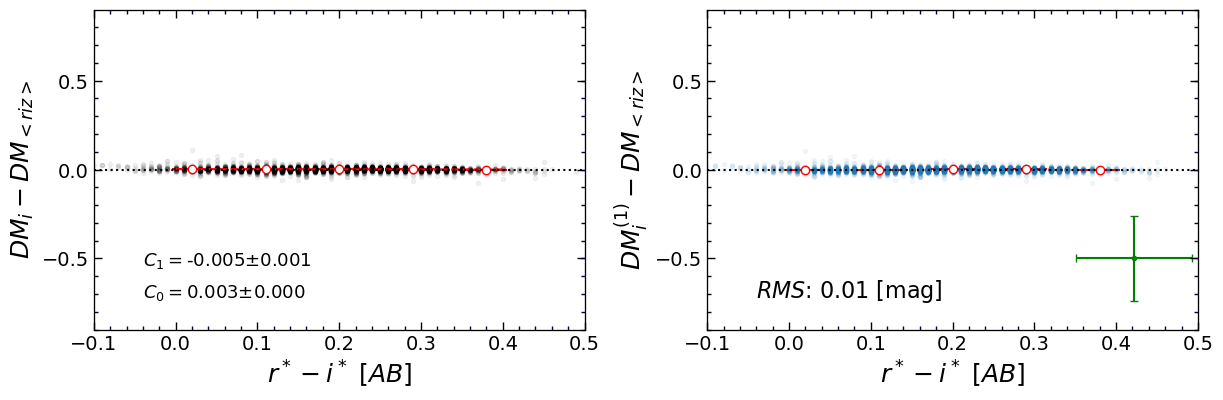

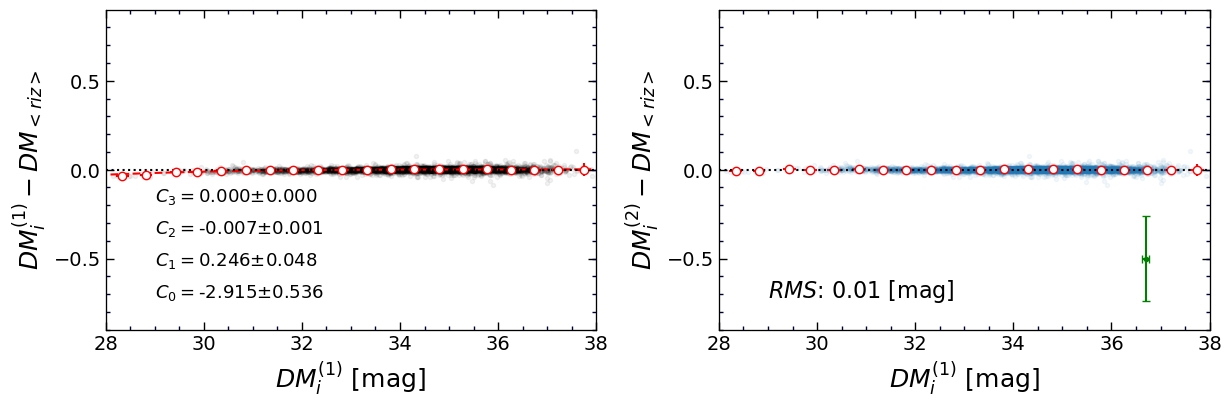

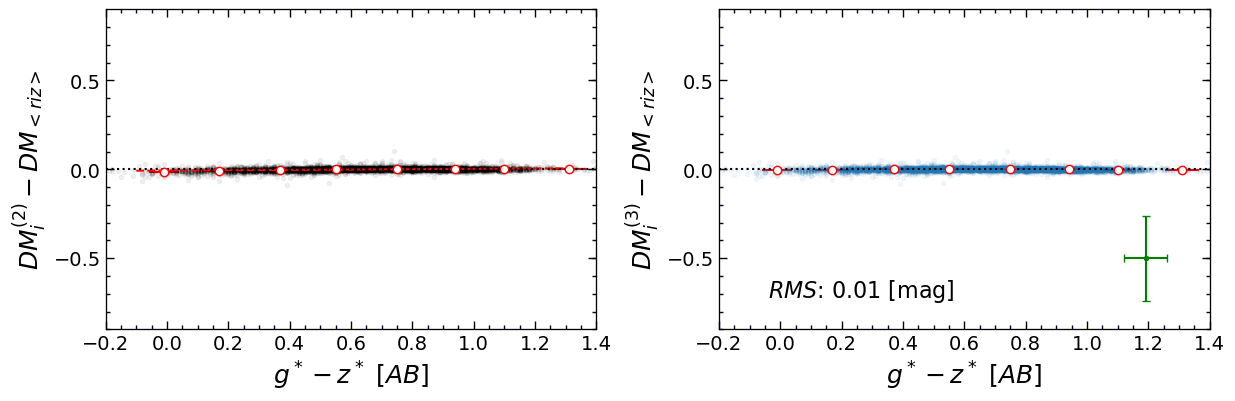

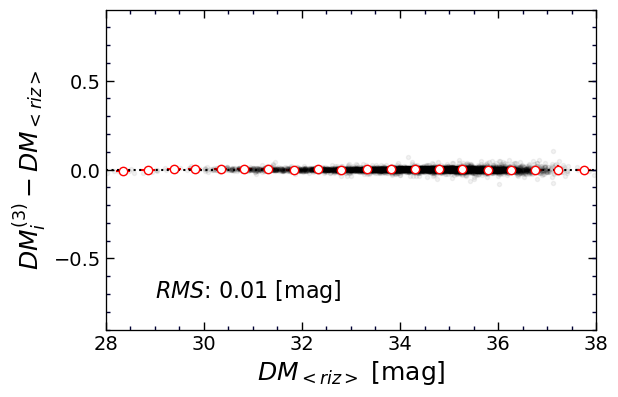

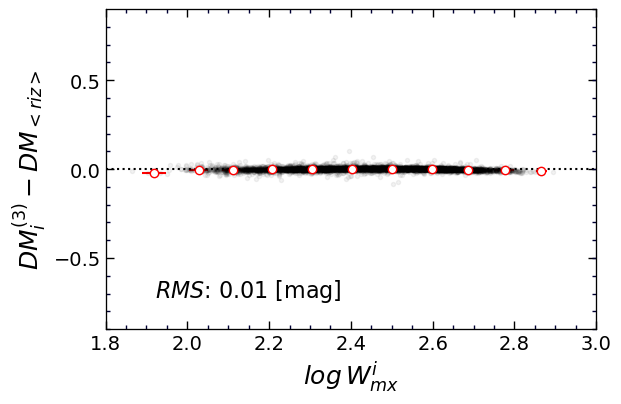

In [34]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1))


DM_av = (DMr_mod+DMi_mod+DMz_mod)/3.
dDM_av = (dDM_r + dDM_i + dDM_z)/3.

axes, DM2i_, fit, cov = adjustDM(DMi_mod, dDM_i, DM_av, dDM_av, r_i, 
                        xlim=(-0.1,0.5), indx=indx, quad=False,
                        xlabel=r'$r^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{i}', 
                        ylabelRef='DM_{<riz>}',
                        ylabel2='DM^{(1)}_{i}',       
                        dx=0.1, coeff=True
                        )



axes, DM2i_, fit, cov = adjustDM(DM2i_, dDM_i, DM_av, dDM_av, DM2i, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM^{(1)}_{i}$'+' [mag]', deg3=True,
                        ylabel='DM^{(1)}_{i}', 
                        ylabel2='DM^{(2)}_{i}',
                        ylabelRef='DM_{< riz >}',
                        dx=0.5, coeff=True,
                        )


axes, DM2i_, fit, cov = adjustDM(DM2i_, dDM_i, DM_av, dDM_av, g_z, 
                        xlim=(-0.2,1.4), indx=indx, quad=False,
                        xlabel=r'$g^*-z^* \/\/ [AB]$',  
                        ylabelRef='DM_{<riz>}',
                        ylabel='DM^{(2)}_{i}', 
                        ylabel2='DM^{(3)}_{i}',       
                        )


axes, _, fit, cov = adjustDM(DM2i_, dDM_i, DM_av, dDM_av, DM_av, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM_{< riz >}$'+' [mag]', 
                        ylabel='DM^{(3)}_{i}', 
                        ylabelRef='DM_{< riz >}',
                        dx = 0.5,
                        single=True,
                        scatter=True,
                        )


axes, _, fit, cov = adjustDM(DM2i_, dDM_i, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(3)}_{i}', 
                        ylabelRef='DM_{<riz>}',
                        dx=0.1, 
                        single=True,
                        scatter=True
                        )

Fit params:
0.106\pm0.002
-0.023\pm0.000
Fit params:
0.012\pm0.005
-0.103\pm0.025
0.183\pm0.030
Fit params:
-0.000\pm0.000
0.013\pm0.002
-0.474\pm0.074
5.630\pm0.835
Fit params:
-0.011\pm0.005
0.055\pm0.024
-0.067\pm0.030
Fit params:
0.022\pm0.001
-0.015\pm0.000
Fit params:
-0.000\pm0.000
0.015\pm0.003
-0.243\pm0.056
Fit params:
-0.006\pm0.004
-0.000\pm0.020
0.034\pm0.024
Fit params:
-0.001\pm0.002
0.000\pm0.000


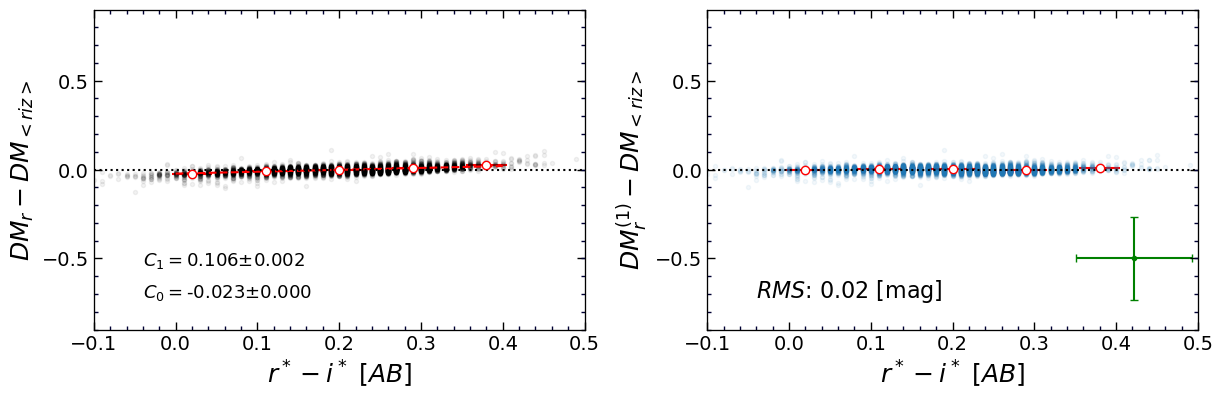

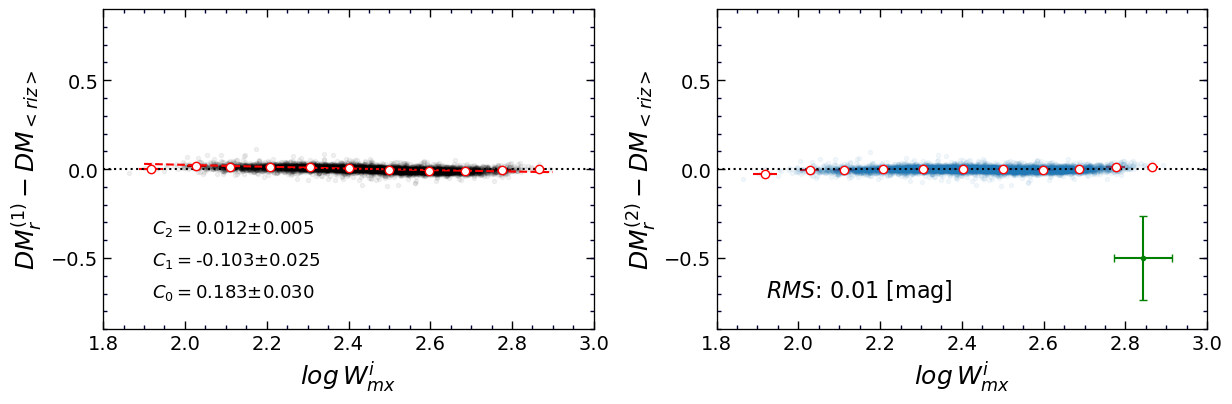

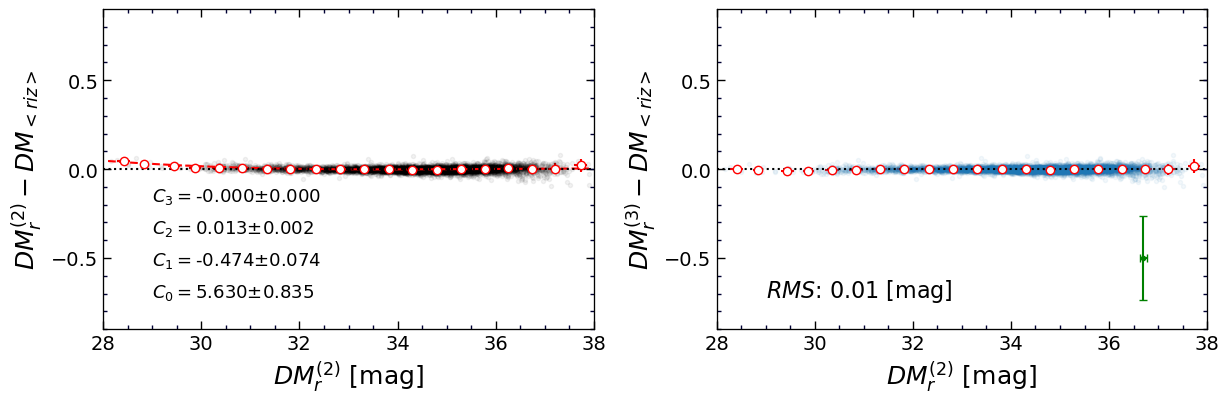

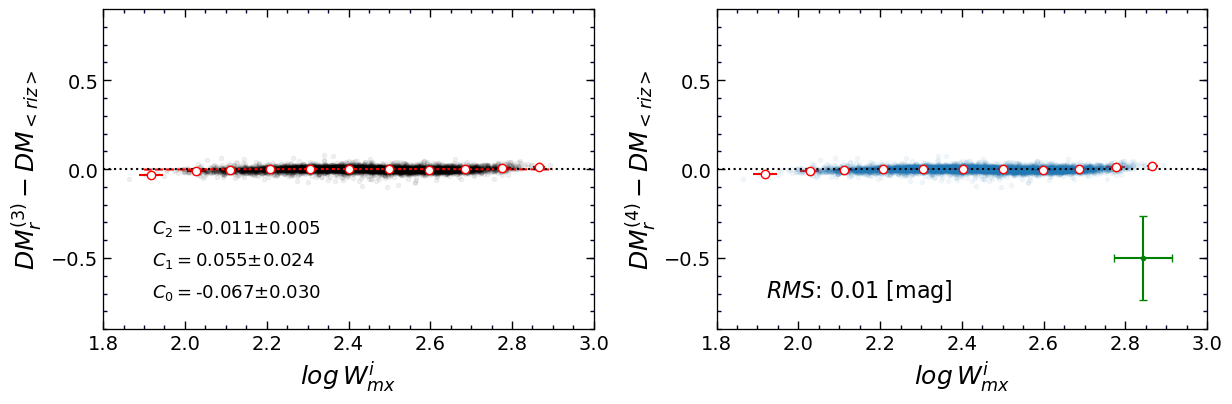

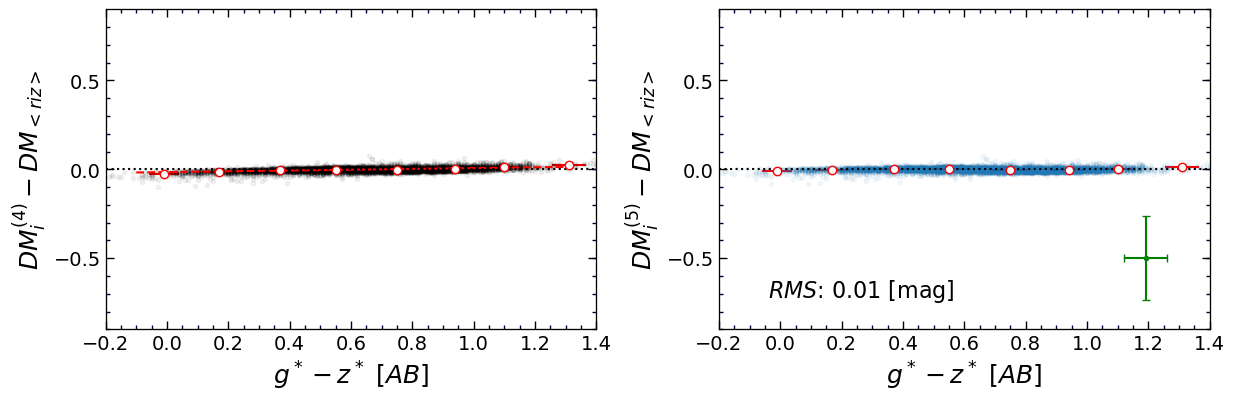

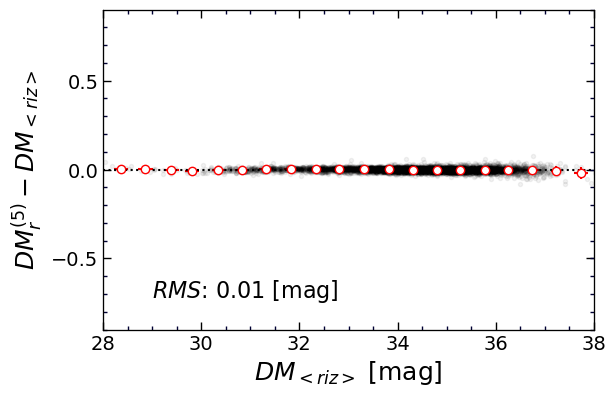

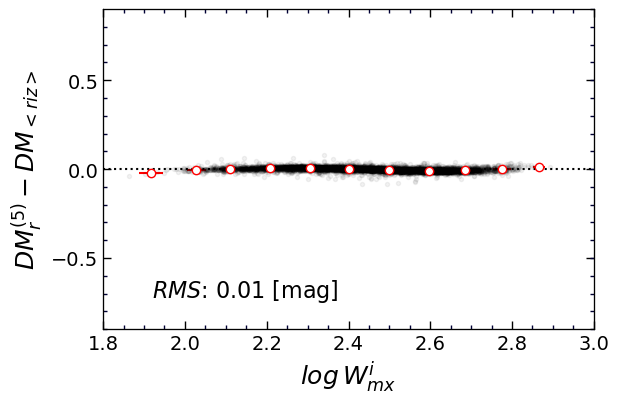

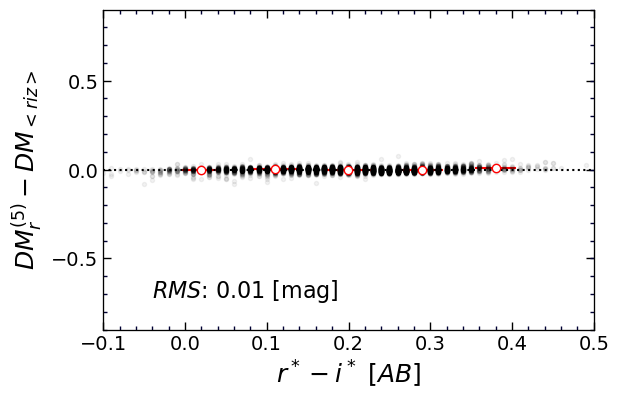

In [35]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1))

axes, DM2r_, fit, cov = adjustDM(DMr_mod, dDM_r, DM_av, dDM_av, r_i, 
                        xlim=(-0.1,0.5), indx=indx, quad=False,
                        xlabel=r'$r^*-i^* \/\/ [AB]$', 
                        ylabel='DM_{r}', 
                        ylabel2='DM^{(1)}_{r}',
                        ylabelRef='DM_{< riz >}',
                        dx=0.1, coeff=True
                        )

axes, DM2r_, fit, cov = adjustDM(DM2r_, dDM_r, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(1)}_{r}', 
                        ylabel2='DM^{(2)}_{r}', 
                        ylabelRef='DM_{< riz >}',
                        dx=0.1, coeff=True,
                        )

axes, DM2r_, fit, cov = adjustDM(DM2r_, dDM_r, DM_av, dDM_av, DM2r, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM^{(2)}_{r}$'+' [mag]', deg3=True,
                        ylabel='DM^{(2)}_{r}', 
                        ylabel2='DM^{(3)}_{r}',
                        ylabelRef='DM_{< riz >}',
                        dx=0.5, coeff=True,
                        )

axes, DM2r_, fit, cov = adjustDM(DM2r_, dDM_r, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(3)}_{r}', 
                        ylabel2='DM^{(4)}_{r}', 
                        ylabelRef='DM_{< riz >}',
                        dx=0.1, coeff=True,
                        )


axes, DM2r_, fit, cov = adjustDM(DM2r_, dDM_r, DM_av, dDM_av, g_z, 
                        xlim=(-0.2,1.4), indx=indx, quad=False,
                        xlabel=r'$g^*-z^* \/\/ [AB]$',  
                        ylabelRef='DM_{<riz>}',
                        ylabel='DM^{(4)}_{i}', 
                        ylabel2='DM^{(5)}_{i}',       
                        )


axes, _, fit, cov = adjustDM(DM2r_, dDM_r, DM_av, dDM_av, DM_av, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM_{< riz >}$'+' [mag]', 
                        ylabel='DM^{(5)}_{r}', 
                        ylabelRef='DM_{< riz >}',
                        dx = 0.5,
                        single=True,
                        scatter=True,
                        )



axes, _, fit, cov = adjustDM(DM2r_, dDM_r, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(5)}_{r}', 
                        ylabelRef='DM_{< riz >}',
                        dx=0.1, 
                        single=True,
                        scatter=True
                        )



axes, _, fit, cov = adjustDM(DM2r_, dDM_r, DM_av, dDM_av, r_i, 
                        xlim=(-0.1,0.5), indx=indx, quad=False,
                        xlabel=r'$r^*-i^* \/\/ [AB]$', 
                        ylabel='DM^{(5)}_{r}',
                        ylabelRef='DM_{< riz >}',
                        dx=0.1, 
                        single=True,
                        scatter=True
                        )

Fit params:
-0.160\pm0.002
0.014\pm0.000
Fit params:
0.050\pm0.005
-0.225\pm0.025
0.247\pm0.030
Fit params:
0.000\pm0.000
-0.009\pm0.002
0.321\pm0.074
-3.859\pm0.825
Fit params:
-0.000\pm0.000
0.000\pm0.004
-0.005\pm0.063
Fit params:
-0.022\pm0.001
0.015\pm0.000


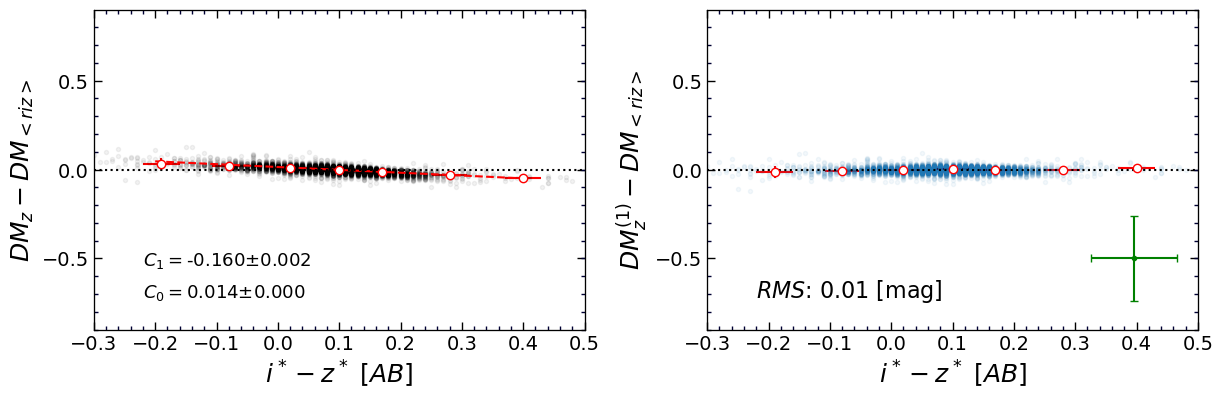

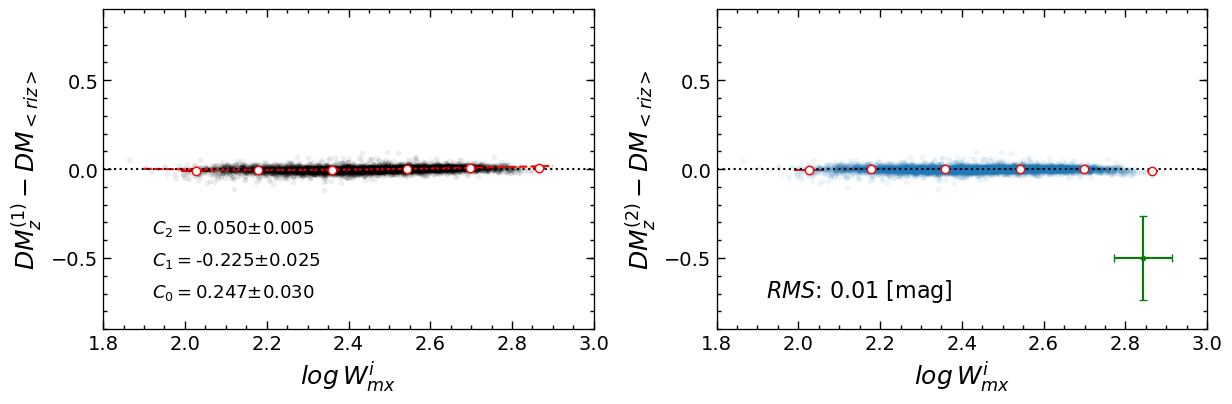

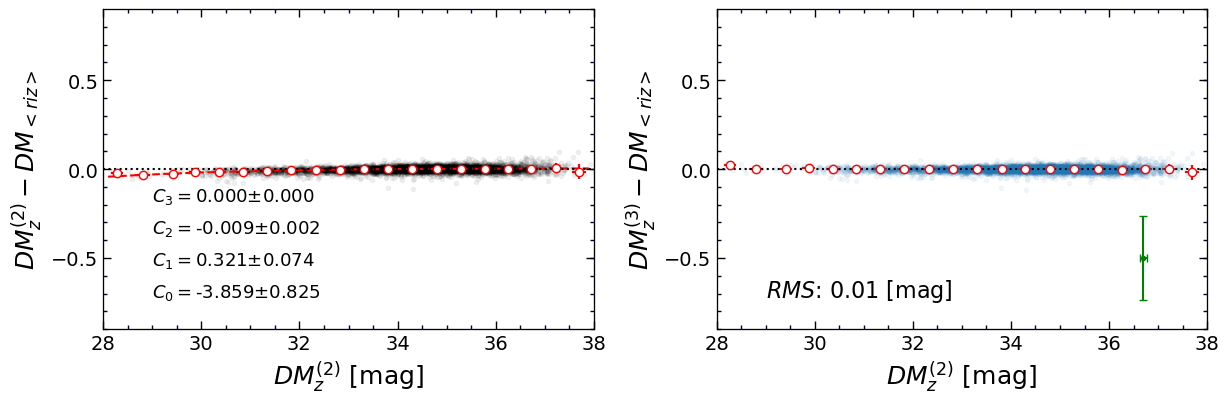

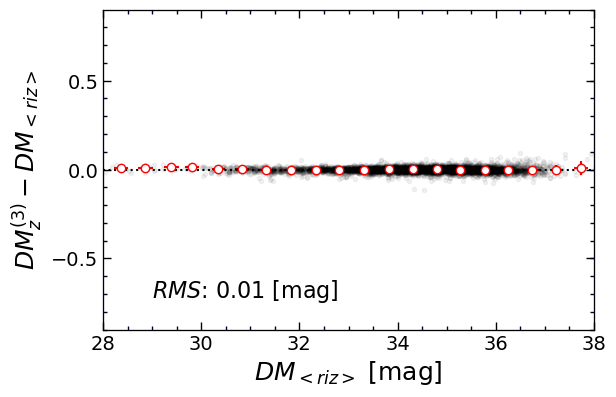

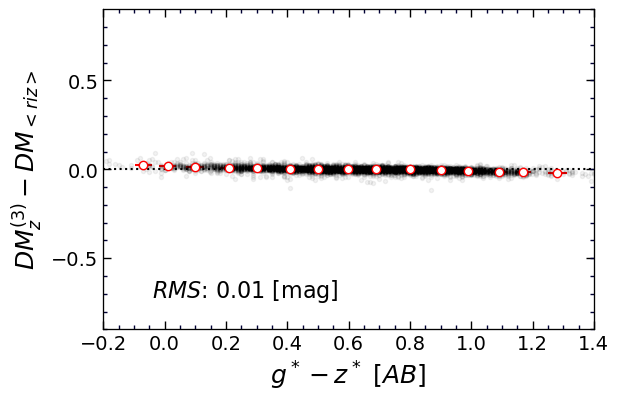

In [36]:
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1))

axes, DM2z_, fit, cov = adjustDM(DMz_mod, dDM_z, DM_av, dDM_av, i_z, 
                        xlim=(-0.3,0.5), indx=indx, quad=False,
                        xlabel=r'$i^*-z^* \/\/ [AB]$', 
                        ylabel='DM_{z}', 
                        ylabel2='DM^{(1)}_{z}',
                        ylabelRef='DM_{< riz >}',
                        coeff=True, dx=0.1
                        )


axes, DM2z_, fit, cov = adjustDM(DM2z_, dDM_z, DM_av, dDM_av, logWimx, 
                        xlim=(1.8,3), indx=indx, quad=True,
                        xlabel=r'$log \/ W^i_{mx}$', 
                        ylabel='DM^{(1)}_{z}', 
                        ylabel2='DM^{(2)}_{z}',
                        ylabelRef='DM_{< riz >}',
                        coeff=True
                        )

axes, DM2z_, fit, cov = adjustDM(DM2z_, dDM_z, DM_av, dDM_av, DM2z, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM^{(2)}_{z}$'+' [mag]', 
                        ylabel='DM^{(2)}_{z}', 
                        ylabel2='DM^{(3)}_{z}',
                        ylabelRef='DM_{< riz >}',
                        dx = 0.5, deg3=True, coeff=True
                        )



axes, _, fit, cov = adjustDM(DM2z_, dDM_z, DM_av, dDM_av, DM_av, 
                        xlim=(28,38), indx=indx, quad=True,
                        xlabel=r'$DM_{< riz >}$'+' [mag]', 
                        ylabel='DM^{(3)}_{z}', 
                        ylabelRef='DM_{< riz >}',
                        single=True, scatter=True, dx=0.5
                        )

axes, _, fit, cov = adjustDM(DM2z_, dDM_z, DM_av, dDM_av, g_z, 
                        xlim=(-0.2,1.4), indx=indx, quad=False,
                        xlabel=r'$g^*-z^* \/\/ [AB]$',
                        ylabel='DM^{(3)}_{z}', 
                        ylabelRef='DM_{< riz >}',
                        single=True, scatter=True, dx=0.1
                        )

In [37]:
# indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (SSqlt>3) & (keep==1) & (WWqlt>3) & 
#                  (w22>0) & (w11>0) & (RS==2))

# print len(indx)
# axes, _, fit, cov = adjustDM(DMw1_mod, dDM_1 , DM_av, dDM_av, iii-w11, 
#                         xlim=(-1.2,0), indx=indx, quad=False, single=False,
#                         xlabel=r'$i^*-W1^* \/\/ [AB]$', 
#                         ylabel='DM_{W1}', 
#                         ylabel2='\overline{DM_{W1}}',
#                         ylabelRef='DM_{< riz >}',
#                         dx = 0.1, coeff=True, deg3=False
#                         )


# axes, DMw1_, fit, cov = adjustDM(DMw1_mod, dDM_1, DM_av, dDM_av, P0, 
#                         xlim=(-4,4), indx=indx, quad=True,
#                         xlabel=r'$P_{1,W2}$', 
#                         ylabel='DM_{W1}', 
#                         ylabel2='DM^{(1)}_{W1}', 
#                         ylabelRef='DM_{< riz >}',
#                         dx=0.5, coeff=True, deg3=False
#                         )



# ############## Never Uncomment for business
# axes, DMw1_, fit, cov = adjustDM(DMw1_, dDM_1, DM_av, dDM_av, logWimx, 
#                         xlim=(2,3), indx=indx, quad=True,
#                         xlabel=r'$log \/ W^i_{mx}$', 
#                         ylabel='DM^{(1)}_{W1}', 
#                         ylabel2='DM^{(2)}_{W1}', 
#                         ylabelRef='DM_{< riz >}',
#                         dx = 0.05, deg3=False,        
#                         coeff=True, rev=True
#                         )


# axes, DMw1_, fit, cov = adjustDM(DMw1_, dDM_1, DM_av, dDM_av, DMw1_, 
#                         xlim=(28,38), indx=indx, quad=True,
#                         xlabel=r'$DM?$', 
#                         ylabel='DM^{(1)}_{W1}', 
#                         ylabel2='DM^{(2)}_{W1}', 
#                         ylabelRef='DM_{< riz >}',
#                         dx = 0.5, deg3=True,        
#                         coeff=True, rev=True
#                         )



# axes, _, fit, cov = adjustDM(DMw1_, dDM_1, DM_av, dDM_av, DM_av, 
#                         xlim=(28,38), indx=indx, quad=True,
#                         xlabel=r'$DM_{< riz >}$'+' [mag]', 
#                         ylabel='DM^{(2)}_{W1}', 
#                         ylabelRef='DM_{< riz >}',
#                         single=True, dx=0.5, scatter=True
#                         )
# #####################

# axes, _, fit, cov = adjustDM(DMw1_, dDM_1, DM_av, dDM_av, iii-w11,
#                         xlim=(-1.2,0), indx=indx, quad=False,
#                         xlabel=r'$i^*-W1^* \/\/ [AB]$', 
#                         ylabel='DM^{(2)}_{W1}', 
#                         ylabelRef='DM_{< riz >}',
#                         single=True,
#                         dx=0.1, scatter=True
#                         )

In [38]:
indx = np.where((Sqlt==0) | (rrr<=0))
DM2r_[indx] = 0
DMr_mod = copy.deepcopy(DM2r_)

indx = np.where((Sqlt==0) | (iii<=0))
DM2i_[indx] = 0
DMi_mod = copy.deepcopy(DM2i_)

indx = np.where((Sqlt==0) | (zzz<=0))
DM2z_[indx] = 0
DMz_mod = copy.deepcopy(DM2z_)


# indx = np.where((Wqlt==0) | (w11<=0))
# DMw1_[indx] = 0
# DMw1_mod = copy.deepcopy(DMw1_)

In [39]:
myTable = Table()

myTable.add_column(Column(data=pgc_tab, name='pgc'))
myTable.add_column(Column(data=Vhel, name='Vh', dtype=np.dtype(int)))
myTable.add_column(Column(data=Vls, name='Vls', dtype=np.dtype(int)))
myTable.add_column(Column(data=V3k, name='V3k', dtype=np.dtype(int)))
myTable.add_column(Column(data=Vmod, name='Vmod', dtype=np.dtype(int)))


f_cosmology = fmod(V3k)
myTable.add_column(Column(data=f_cosmology, name='f_cosmology', format='%0.3f'))


myTable.add_column(Column(data=logWimx, name='logWimx', format='%0.3f'))
myTable.add_column(Column(data=logWimx_e, name='logWimx_e', format='%0.3f'))
myTable.add_column(Column(data=inc, name='inc', dtype=np.dtype(int)))
myTable.add_column(Column(data=table['Sqlt'], name='Sqlt', dtype=np.dtype(int)))
myTable.add_column(Column(data=table['Wqlt'], name='Wqlt', dtype=np.dtype(int)))

######################################################################

DM_best = DMr_mod*0
dDM_best = DMr_mod*0
DM_src = DMr_mod*0

for j in range(len(DMz_mod)):
    
    idd = pgc_tab[j]
    if DMr_mod[j]>0 and DMi_mod[j]>0 and DMz_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = (DMr_mod[j]+DMi_mod[j]+DMz_mod[j])/3.
        dDM_best[j] = np.median([dDM_r[j],dDM_i[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and DMi_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = (DMr_mod[j]+DMi_mod[j])/2.
        dDM_best[j] = np.median([dDM_r[j],dDM_i[j]])
        DM_src[j] = 1
    elif DMz_mod[j]>0 and DMi_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = (DMz_mod[j]+DMi_mod[j])/2.
        dDM_best[j] = np.median([dDM_i[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and DMz_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = (DMr_mod[j]+DMz_mod[j])/2.      
        dDM_best[j] = np.median([dDM_r[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = DMr_mod[j]
        dDM_best[j] = dDM_r[j]
        DM_src[j] = 1
    elif DMi_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = DMi_mod[j]
        dDM_best[j] = dDM_i[j]
        DM_src[j] = 1
    elif DMz_mod[j]>0 and not idd in pgc_drop_riz:
        DM_best[j] = DMz_mod[j]
        dDM_best[j] = dDM_z[j]
        DM_src[j] = 1
    elif DMw1_mod[j]>0 and not idd in pgc_drop_w1:
        DM_best[j] = DMw1_mod[j]
        dDM_best[j] = dDM_1[j]
        DM_src[j] = 2
##################################
    elif DMr_mod[j]>0 and DMi_mod[j]>0 and DMz_mod[j]>0:
        DM_best[j] = (DMr_mod[j]+DMi_mod[j]+DMz_mod[j])/3.
        dDM_best[j] = np.median([dDM_r[j],dDM_i[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and DMi_mod[j]>0:
        DM_best[j] = (DMr_mod[j]+DMi_mod[j])/2.
        dDM_best[j] = np.median([dDM_r[j],dDM_i[j]])
        DM_src[j] = 1
    elif DMz_mod[j]>0 and DMi_mod[j]>0:
        DM_best[j] = (DMz_mod[j]+DMi_mod[j])/2.
        dDM_best[j] = np.median([dDM_i[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0 and DMz_mod[j]>0:
        DM_best[j] = (DMr_mod[j]+DMz_mod[j])/2.      
        dDM_best[j] = np.median([dDM_r[j],dDM_z[j]])
        DM_src[j] = 1
    elif DMr_mod[j]>0:
        DM_best[j] = DMr_mod[j]
        dDM_best[j] = dDM_r[j]
        DM_src[j] = 1
    elif DMi_mod[j]>0:
        DM_best[j] = DMi_mod[j]
        dDM_best[j] = dDM_i[j]
        DM_src[j] = 1
    elif DMz_mod[j]>0:
        DM_best[j] = DMz_mod[j]
        dDM_best[j] = dDM_z[j]
        DM_src[j] = 1
    elif DMw1_mod[j]>0:
        DM_best[j] = DMw1_mod[j]
        dDM_best[j] = dDM_1[j]
        DM_src[j] = 2 
    if idd in extraDrops:
        DM_best[j] = 0
        dDM_best[j] = 0
        DM_src[j] = 0         
        

myTable.add_column(Column(data=DM_best, name='DM_best', format='%0.2f'))
myTable.add_column(Column(data=dDM_best, name='dDM_best', format='%0.2f'))

######################################################################

myTable.add_column(Column(data=DMr_mod, name='DMr', format='%0.2f'))
myTable.add_column(Column(data=dDM_r, name='dDMr', format='%0.2f'))
myTable.add_column(Column(data=rms_r, name='RMS_r', format='%0.2f'))
myTable.add_column(Column(data=DM_r, name='DMr_raw', format='%0.2f'))

myTable.add_column(Column(data=DMi_mod, name='DMi', format='%0.2f'))
myTable.add_column(Column(data=dDM_i, name='dDMi', format='%0.2f'))
myTable.add_column(Column(data=rms_i, name='RMS_i', format='%0.2f'))
myTable.add_column(Column(data=DM_i, name='DMi_raw', format='%0.2f'))

myTable.add_column(Column(data=DMz_mod, name='DMz', format='%0.2f'))
myTable.add_column(Column(data=dDM_z, name='dDMz', format='%0.2f'))
myTable.add_column(Column(data=rms_z, name='RMS_z', format='%0.2f'))
myTable.add_column(Column(data=DM_z, name='DMz_raw', format='%0.2f'))

myTable.add_column(Column(data=DMw1_mod, name='DM_w1', format='%0.2f'))
myTable.add_column(Column(data=dDM_1, name='dDM_w1', format='%0.2f'))
myTable.add_column(Column(data=rms_w1, name='RMS_w1', format='%0.2f'))
myTable.add_column(Column(data=DM_1, name='DMw1_raw', format='%0.2f'))


myTable.add_column(Column(data=ggg, name='ggg', format='%0.2f'))
myTable.add_column(Column(data=rrr, name='rrr', format='%0.2f'))
myTable.add_column(Column(data=iii, name='iii', format='%0.2f'))
myTable.add_column(Column(data=zzz, name='zzz', format='%0.2f'))
myTable.add_column(Column(data=w11, name='w1', format='%0.2f'))
myTable.add_column(Column(data=w22, name='w2', format='%0.2f'))
myTable.add_column(Column(data=ra, name='RA', format='%0.4f'))
myTable.add_column(Column(data=dec, name='DEC', format='%0.4f'))
myTable.add_column(Column(data=gl, name='gl', format='%0.4f'))
myTable.add_column(Column(data=gb, name='gb', format='%0.4f'))
myTable.add_column(Column(data=sgl, name='sgl', format='%0.4f'))
myTable.add_column(Column(data=sgb, name='sgb', format='%0.4f'))
myTable.add_column(Column(data=pgc1, name='pgc1', dtype=np.dtype(int)))
myTable.add_column(Column(data=nest, name='Nest', dtype=np.dtype(int)))
myTable.add_column(Column(data=Vmodg, name='Vmodg', dtype=np.dtype(int)))
myTable.add_column(Column(data=Nkt, name='Nkt', dtype=np.dtype(int)))
myTable.add_column(Column(data=N15, name='N15', dtype=np.dtype(int)))
myTable.add_column(Column(data=sglg, name='sglg', format='%0.4f'))
myTable.add_column(Column(data=sgbg, name='sgbg', format='%0.4f'))
myTable.add_column(Column(data=RS, name='RS'))
myTable.add_column(Column(data=P0, name='P0'))
myTable.add_column(Column(data=DM_src, name='DM_src', dtype=np.dtype(int)))

## to be used on EDD
myTable.write('DMs_EDD.csv.test', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

# Adding more columns to help the construction of CF4

In [40]:
# myTable.add_column(Column(data=SSqlt, name='Sqlt', dtype=np.dtype(int)))
# myTable.add_column(Column(data=WWqlt, name='Wqlt', dtype=np.dtype(int)))

# ## to be used to construct all CF4 distnace catalog
# myTable.write('CF4_TFdistances.csv', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)


In [41]:
import pandas as pd
import numpy as np

df = pd.read_csv('DMs_EDD.csv.test', delimiter='|')
df = df.rename(columns=lambda x: x.strip())

df = df.rename(columns=lambda x: x if x!='DM_w1' else 'DMw1')
df = df.rename(columns=lambda x: x if x!='dDM_w1' else 'dDMw1')

df.head()

,pgc,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,inc,Sqlt,...,pgc1,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src
0,2,5004,5296,4726,4786,1.013,2.744,0.029,52,0,...,73150,200275,4976,0,7,341.4922,20.7395,2,2.02,2
1,4,4458,4706,4109,4154,1.011,2.189,0.014,85,5,...,120,202766,4154,0,0,316.0587,18.4514,2,-2.75,1
2,12,6548,6685,6195,6297,1.016,2.606,0.021,82,0,...,12,210177,6279,0,1,286.4249,11.3510,2,0.56,2
3,16,5667,5809,5312,5387,1.014,2.515,0.025,65,5,...,16,211419,5434,0,1,287.6120,11.7030,2,0.92,1
4,55,4779,5052,4454,4507,1.012,2.260,0.025,80,5,...,55,0,4507,0,0,327.0996,19.7763,2,-2.83,1


In [42]:
print(df.columns)
print(len(df))

Index([u'pgc', u'Vh', u'Vls', u'V3k', u'Vmod', u'f_cosmology', u'logWimx',
       u'logWimx_e', u'inc', u'Sqlt', u'Wqlt', u'DM_best', u'dDM_best', u'DMr',
       u'dDMr', u'RMS_r', u'DMr_raw', u'DMi', u'dDMi', u'RMS_i', u'DMi_raw',
       u'DMz', u'dDMz', u'RMS_z', u'DMz_raw', u'DMw1', u'dDMw1', u'RMS_w1',
       u'DMw1_raw', u'ggg', u'rrr', u'iii', u'zzz', u'w1', u'w2', u'RA',
       u'DEC', u'gl', u'gb', u'sgl', u'sgb', u'pgc1', u'Nest', u'Vmodg',
       u'Nkt', u'N15', u'sglg', u'sgbg', u'RS', u'P0', u'DM_src'],
      dtype='object')
10737


In [43]:
gg = df.loc[:, ['pgc', 'Vls', 'V3k', 'f_cosmology']]

gg['f_cosmology'] = df['f_cosmology'].apply(lambda x: "%.3f"%np.float(x))

gg['DM_best'] = df['DM_best'].apply(lambda x: "%.2f"%np.float(x))+'$\pm$'+df['dDM_best'].apply(lambda x: "%.2f"%np.float(x))
gg['DM_best'] = gg['DM_best'].apply(lambda x: x if x!='0.00$\pm$0.00' else '')

for band in ['r', 'i', 'z', 'w1']:

    gg['DM'+band] = df['DM'+band].apply(lambda x: "%.2f"%np.float(x))+'$\pm$'+df['dDM'+band].apply(lambda x: "%.2f"%np.float(x))
    gg['DM'+band] = gg['DM'+band].apply(lambda x: x if x!='0.00$\pm$0.00' else '')
    gg['DM'+band+'_rms'] = df['RMS_'+band].apply(lambda x: "%.2f"%np.float(x))
    gg['DM'+band+'_rms'] = gg['DM'+band+'_rms'].apply(lambda x: x if x!='0.00' else '')

    
print len(keep)
print len(keep_riz)
print len(keep_w1)
print len(gg)

gg = gg[(keep==1) & ((keep_riz!=0) | (keep_w1!=0))]

keep_riz_ = keep_riz[(keep==1) & ((keep_riz!=0) | (keep_w1!=0))]
keep_w1_  = keep_w1[(keep==1) & ((keep_riz!=0) | (keep_w1!=0))]

gg['DMr'][keep_riz_==0] = ''
gg['DMi'][keep_riz_==0] = ''
gg['DMz'][keep_riz_==0] = ''
gg['DMw1'][keep_w1_==0] = ''


gg['DMr_rms'][keep_riz_==0] = ''
gg['DMi_rms'][keep_riz_==0] = ''
gg['DMz_rms'][keep_riz_==0] = ''
gg['DMw1_rms'][keep_w1_==0] = ''   
    
gg.to_csv('CF4_TFdist_Table4.txt', sep='&', index=False)

print(len(gg))

print(gg[gg['pgc']==6137])
# gg.head(20)

10737
10737
10737
10737
9789
Empty DataFrame
Columns: [pgc, Vls, V3k, f_cosmology, DM_best, DMr, DMr_rms, DMi, DMi_rms, DMz, DMz_rms, DMw1, DMw1_rms]
Index: []


In [44]:
df_edd = df[(keep==1) & ((keep_riz!=0) | (keep_w1!=0))]
df_edd = df_edd.drop(['Vh', 'Vmod', 'logWimx', 'logWimx_e', 'inc', 'Sqlt', 'Wqlt'], axis=1)
df_edd = df_edd.drop(['DMr_raw', 'DMi_raw', 'DMz_raw', 'DMw1_raw'], axis=1)
df_edd = df_edd.drop(['ggg','rrr','iii','zzz','w1','w2','RA','DEC','gl','gb',
                      'sgl','sgb','pgc1','Nest','Vmodg','Nkt','N15','sglg',
                      'sgbg','RS','P0'], axis=1)

columnsTitles = ['pgc', 'DM_best', 'dDM_best', 'Vls', 'V3k', 'f_cosmology', 
                 'DMr', 'dDMr', 'RMS_r', 
                 'DMi', 'dDMi', 'RMS_i', 
                 'DMz', 'dDMz', 'RMS_z', 
                 'DMw1', 'dDMw1', 'RMS_w1']
df_edd = df_edd.reindex(columns=columnsTitles)

In [45]:
df_edd.to_csv('TF_CF4_Distpaper_bar', sep='|', index=False)

len(df_edd)

9789

In [46]:
df_edd.head(10)

,pgc,DM_best,dDM_best,Vls,V3k,f_cosmology,DMr,dDMr,RMS_r,DMi,dDMi,RMS_i,DMz,dDMz,RMS_z,DMw1,dDMw1,RMS_w1
0,2,34.24,0.29,5296,4726,1.013,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.24,0.29,0.48
1,4,33.29,0.17,4706,4109,1.011,33.31,0.16,0.56,33.29,0.17,0.60,33.28,0.17,0.59,33.26,0.17,0.66
2,12,35.03,0.22,6685,6195,1.016,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35.03,0.22,0.48
3,16,34.70,0.24,5809,5312,1.014,34.70,0.23,0.39,34.70,0.24,0.40,34.69,0.24,0.40,34.71,0.25,0.53
4,55,34.00,0.24,5052,4454,1.012,34.00,0.23,0.56,34.00,0.24,0.59,34.01,0.24,0.59,34.09,0.25,0.65
5,68,34.81,0.37,7740,7338,1.019,34.80,0.36,0.52,34.82,0.37,0.52,34.81,0.38,0.52,34.72,0.41,0.61
6,70,35.12,0.12,7040,6447,1.017,35.10,0.12,0.35,35.12,0.12,0.39,35.12,0.12,0.40,35.08,0.10,0.48
7,76,34.73,0.16,7183,6583,1.017,34.73,0.16,0.35,34.73,0.16,0.39,34.74,0.16,0.40,34.77,0.15,0.48
8,92,33.25,0.18,5592,5015,1.013,33.27,0.17,0.56,33.24,0.18,0.60,33.23,0.18,0.59,0.00,0.00,0.00
9,94,33.89,0.32,4367,3995,1.011,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.89,0.32,0.65


In [47]:
df_edd.DM_best[df_edd['pgc']==32821]

3764    31.79
Name: DM_best, dtype: float64

In [48]:
32821 in pgc_drop_w1


True